# QUESTION
In a churn prediction problem, define a target metric to measure user engagement. How would you define an engaged vs. unengaged user? Please provide the business justification and associated visualisations / rationale
in choosing your definition of engagement.

# ANSWER
The [definition](https://en.wikipedia.org/wiki/Customer_attrition) of churn is the loss of a customers or clients. 
In our scenario, we can define an unengaged user a someone that stops making any transactions, and therefore stops using the service. The main challenge when tackling a churn prediction problem, is to come out with a metric to measure churn accurately, that takes into account that users may just temporarily stop using the service. In this notebook I will try to find the optimal inactivity lenght required to consider a user unengaged, that would also make sense from business prespective. 

Table of content:
- Data preparation: just some data preparation.
- Defining churn metric: definition of churn and also try to understand the optimal unengagement period using “gap” analysis
- Looking at churn rates: look at average lifespan using survival analysis.
- Preparing data for churn prediction: feature engineering and data preparation for churn prediction phase.


In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy.random as rand
import scipy.stats as stats

from lifelines.plotting import plot_lifetimes
from lifelines import KaplanMeierFitter
from statsmodels.stats import proportion

In [2]:
plt.rcParams["figure.figsize"] = (40, 20)
plt.rcParams["font.size"] = 32

## 1 - Data preparation
In this step I am just transforming the data into a preliminary format that will be used to explore assumtions and understand metrics

Read the data:

In [3]:
devices = pd.read_csv("../data/rev-devices.csv")
notifications = pd.read_csv("../data/rev-notifications.csv", parse_dates=['created_date'])
users = pd.read_csv("../data/rev-users.csv")
transactions = pd.read_csv("../data/rev-transactions.csv", parse_dates=['created_date'])

In [4]:
user_completed_transactions_by_month = transactions[transactions.transactions_state == 'COMPLETED'] \
                                            .set_index('created_date') \
                                            .groupby(['user_id', pd.Grouper(freq="M")]).size().to_frame("transaction_count")

In [5]:
current_date = user_completed_transactions_by_month.reset_index()['created_date'].max()
print("We will assume that today is {}, and that if an user is active then is still active.".format(current_date))

We will assume that today is 2019-05-31 00:00:00, and that if an user is active then is still active.


In [6]:
user_registration_date = user_completed_transactions_by_month.reset_index().groupby('user_id')['created_date'].min()

def create_range(reg_date):
    return pd.DataFrame(pd.date_range(start=reg_date, end=current_date, freq='M'))

user_full_ranges = user_registration_date.reset_index().groupby('user_id').apply(lambda x: create_range(x['created_date'][0]))
user_full_ranges = user_full_ranges.reset_index().drop(columns=['level_1']).rename(columns={0:"date"})

In [7]:
user_transactions = pd.merge(user_full_ranges, user_completed_transactions_by_month.reset_index(), 
                     left_on=['user_id', 'date'], right_on=['user_id', 'created_date'], how='left')\
                        .drop(columns=['created_date']).fillna(0)

## 2 - Defining Churn Metrics 

In order to understand churn (or unengaged users) I need to have a definition for such event. In this exercise the unit of measure of time will be months, but same would apply if time orizon would be weeks or quarters.  

The ***inactivity period*** is the number of months necessary to define a user churned.
A naive approach would be to define the ***inactivity period*** with fixed number of months, let's say 2, and consider any user that do not have any activity (i.e. completed transactions) after 2 months as churned. 

A better approach would be to look at the data and come out with the right inactivity period necessary to label a user churned.

Calculating the inactivity period is no easy task. It is necessary to come out with a number that is not too short to get too many *false negatives* (i.e. users that only temporarly do not have any activities) but neither too late, otherwise would be too late to come out with an action, and try to reactivate them.

**CALCULATING GAPS**
In order to come out with the right inactivity period, a good idea is to look at gaps.
A *gap* is a block of consecutives months of inactivity but which has later again user activity. In a way, it is a sort of false negative, the user seems inactive, but has later again activity. It is not considered a *gap* if there is no furhter activity (i.e. the user churn) or there is no more data available. A *gap* withouth any later activity, is just a churn event.
The following functions calculates for each user how many *gaps* were found. 

In [8]:
a = [2, 3, 4, 0, 5, 6, 0, 0, 0, 7, 0, 0, 5, 4, 2, 0, 0, 0, 0]

def get_false_negatives(s):
    false_negatives = []
    stack = []
    for i, elem in enumerate(s):
        if elem == 0:
            stack.append(i)
        else:
            if len(stack) > 0:
                false_negatives.append(len(stack))
                stack = []

    return false_negatives

assert get_false_negatives(a) == [1, 3, 2]

In [9]:
counter = {}
def monitor_gaps(gap_array):
    for elem in gap_array:
        elem_counter = counter.get(elem, 0)
        elem_counter += 1
        counter[elem] = elem_counter

_=user_transactions.groupby('user_id')['transaction_count'].apply(get_false_negatives).apply(monitor_gaps)
gaps_df = pd.DataFrame(sorted(counter.items()), columns=['gap size', 'frequency'])

### Plotting gaps
Below I plot the number of gaps found in the data. In the data there are around 6600 '1 month' gaps, around 2700 '2 months' gaps, and so on.

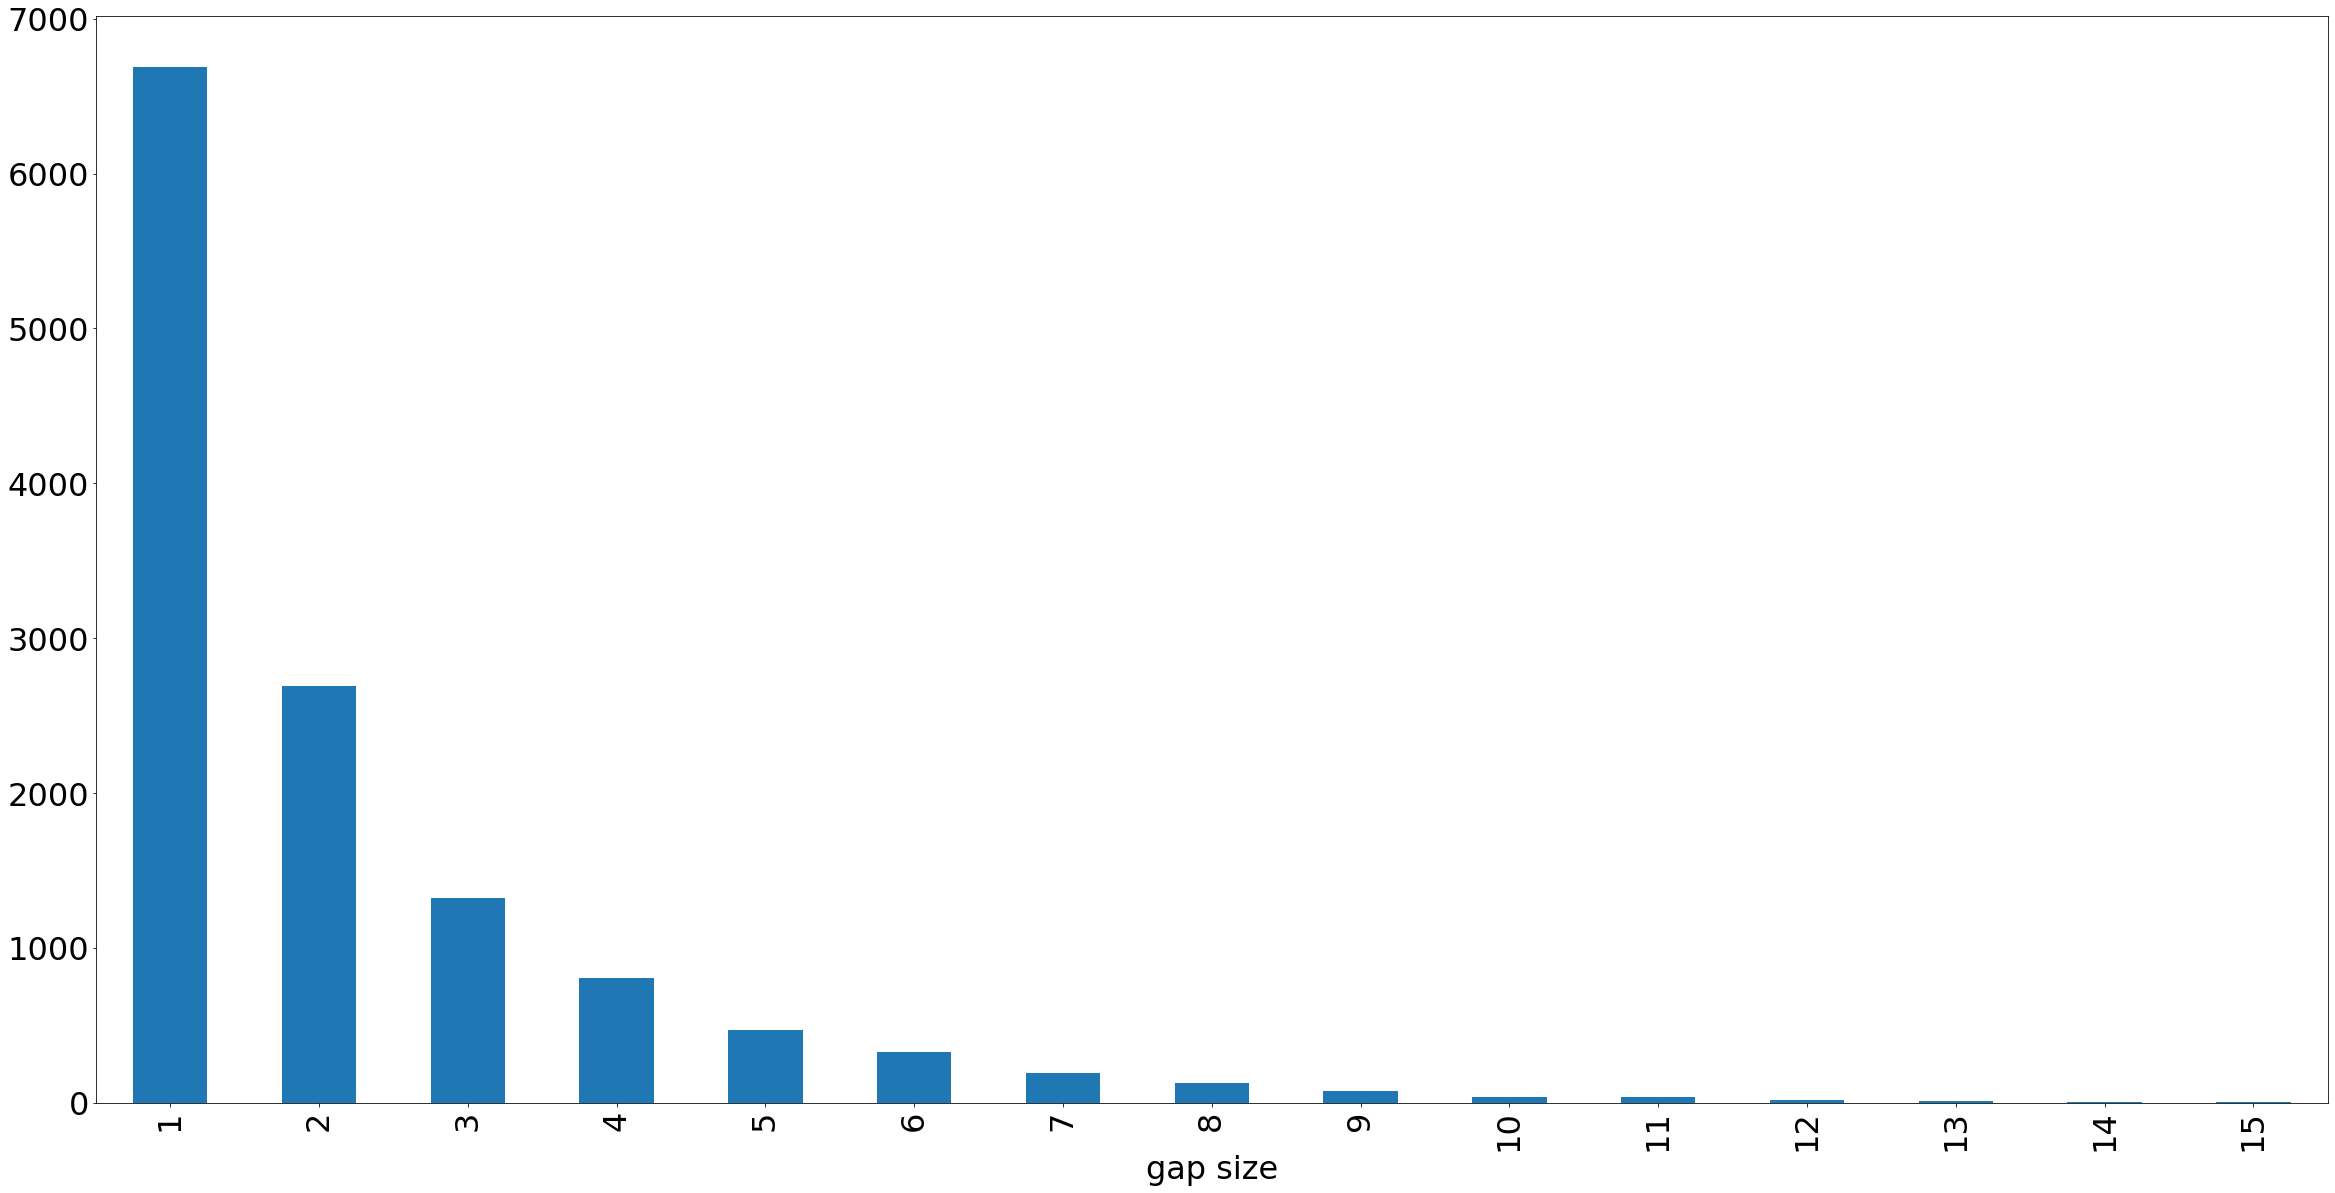

In [10]:
ax = gaps_df.set_index('gap size')['frequency'].plot(kind="bar")

**How long should the inactivity period be then?**
I like going with the p-value threshold usually, which says that we want to be able to catch 95% of the cases correctly.

In [11]:
gaps_df["cumulative_percentage"] = gaps_df.frequency.div(gaps_df.frequency.sum()).cumsum()

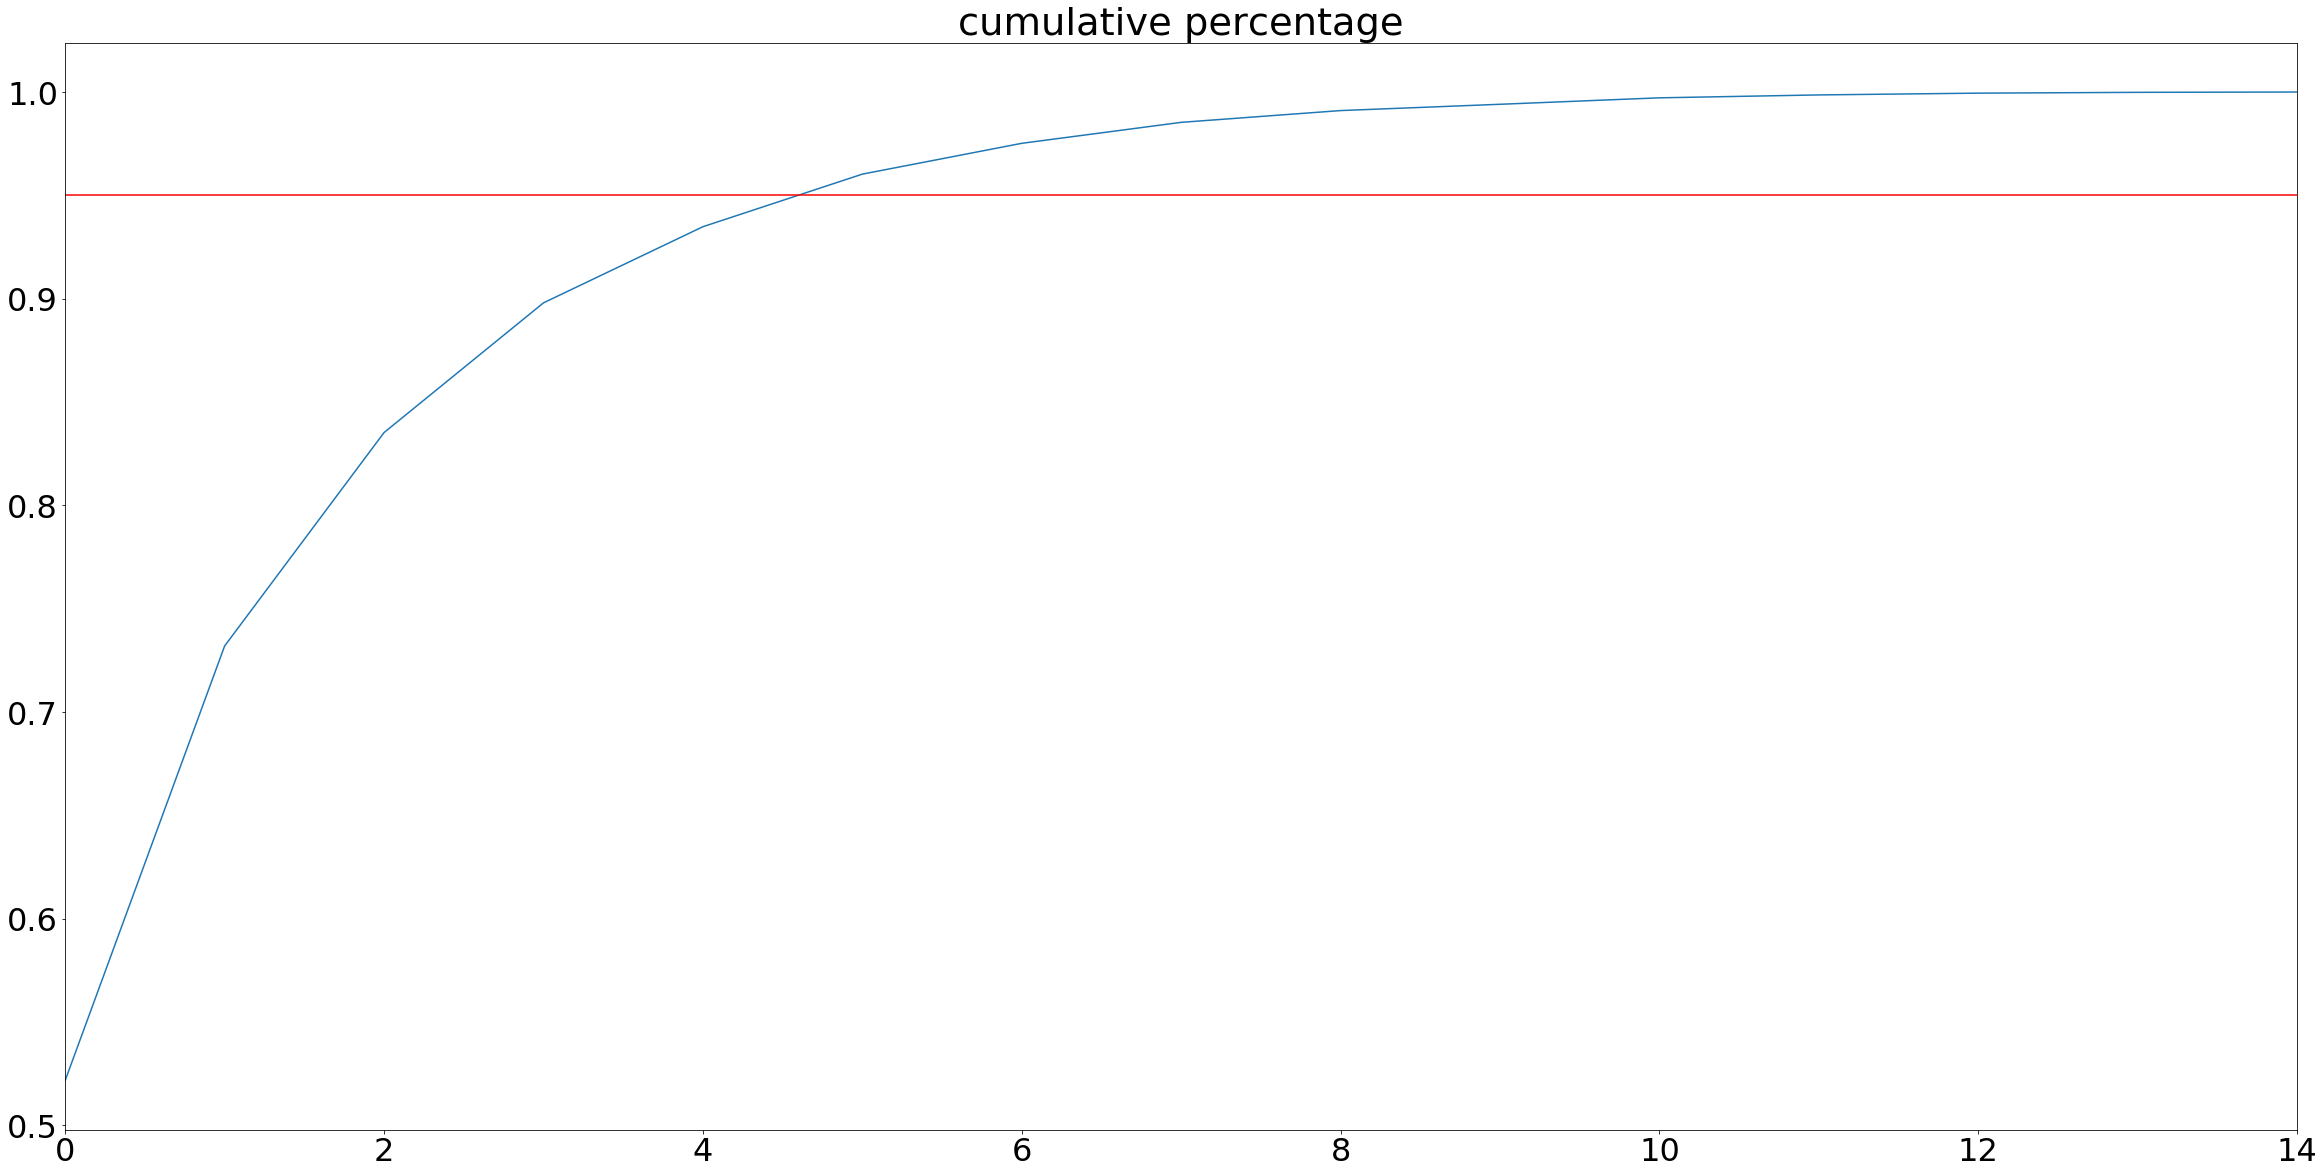

In [12]:
ax = gaps_df["cumulative_percentage"].plot()
ax.axhline(y=0.95, color="red")
_=ax.set_title("cumulative percentage")

In [13]:
gaps_df

,gap size,frequency,cumulative_percentage
0,1,6686,0.521814
1,2,2693,0.731991
2,3,1323,0.835245
3,4,804,0.897994
4,5,472,0.934832
5,6,326,0.960275
6,7,191,0.975181
7,8,130,0.985327
8,9,73,0.991025
9,10,39,0.994069


It looks like that around 6 months we are able to avoid 95% of false negatives. However, it seems quite a long time to be honest. Waiting 6 months for user inactivity it feels not correct. I will instead use 3 months as inactivity period. This should still be acceptable as it will avoids about 83% of false negatives. Furthermore, even if someone make a transaction after 6 months of inactivity, it doesn't seems too correct to consider she still an engaged user. Hence:

#### DEFINITION:  CHURN TIME (aka INACTIVITY PERIOD) = 3 months without any `COMPLETED` transaction

## 3 - Looking at churn rates using survival analysis (Univariate modelling)
I am going to calculate survival rates using lifelines package.

Traditionally, survival analysis was developed to measure lifespans of individuals. An actuary or health professional would ask questions like “how long does this population live for?”, and answer it using survival analysis. For example, the population may be a nation’s population (for actuaries), or a population stricken by a disease (in the medical professional’s case). Traditionally, sort of a morbid subject.

But survival analysis can be applied to not only births and deaths, but any duration. In our case a birth is a user who joins the service, and a death is when the user leaves the service (churn).

#### Censoring
At the time you want to make inferences about durations, it is possible that not all the churn events have occurred yet. For example, a medical professional will not wait 50 years for each individual in the study to pass away before investigating – he or she is interested in making decisions after only a few years, or months possibly.

The individuals in a population who have not been subject to the death event are labeled as right-censored, i.e., we did not (or can not) view the rest of their life history due to some external circumstances. All the information we have on these individuals are their current lifetime durations (which is naturally less than their actual lifetimes).

*A common mistake data analysts make is choosing to ignore the right-censored individuals.*
 If we want to estimate the average lifetime of our population (how long on average users use the product), and we naively decided to not included the right-censored individuals, it is clear that we would be severely underestimating the true average lifespan.


### Calculating median life span
To calculate more accurately the median life span I will use survival analysis.

The function below returns the age in months of each user and if it is censored or not.

In [14]:
def get_life_span(data, threshold=3):
    zeros_counter = 0
    for i, elem in enumerate(data, 1):
        if elem == 0:
            zeros_counter += 1
        else:
            zeros_counter = 0

        if zeros_counter == threshold:
            return pd.Series({"age":i, "censored":False})

    return pd.Series({"age":len(data), "censored":True})

In [15]:
age_censor_df = user_transactions.groupby(user_transactions.user_id).transaction_count.apply(get_life_span)
age_censor_df = age_censor_df.unstack(level=1)

In [16]:
CURRENT_TIME = max(age_censor_df.age)
print("Maximum obseravle life span is {} months.".format(CURRENT_TIME))

Maximum obseravle life span is 17 months.


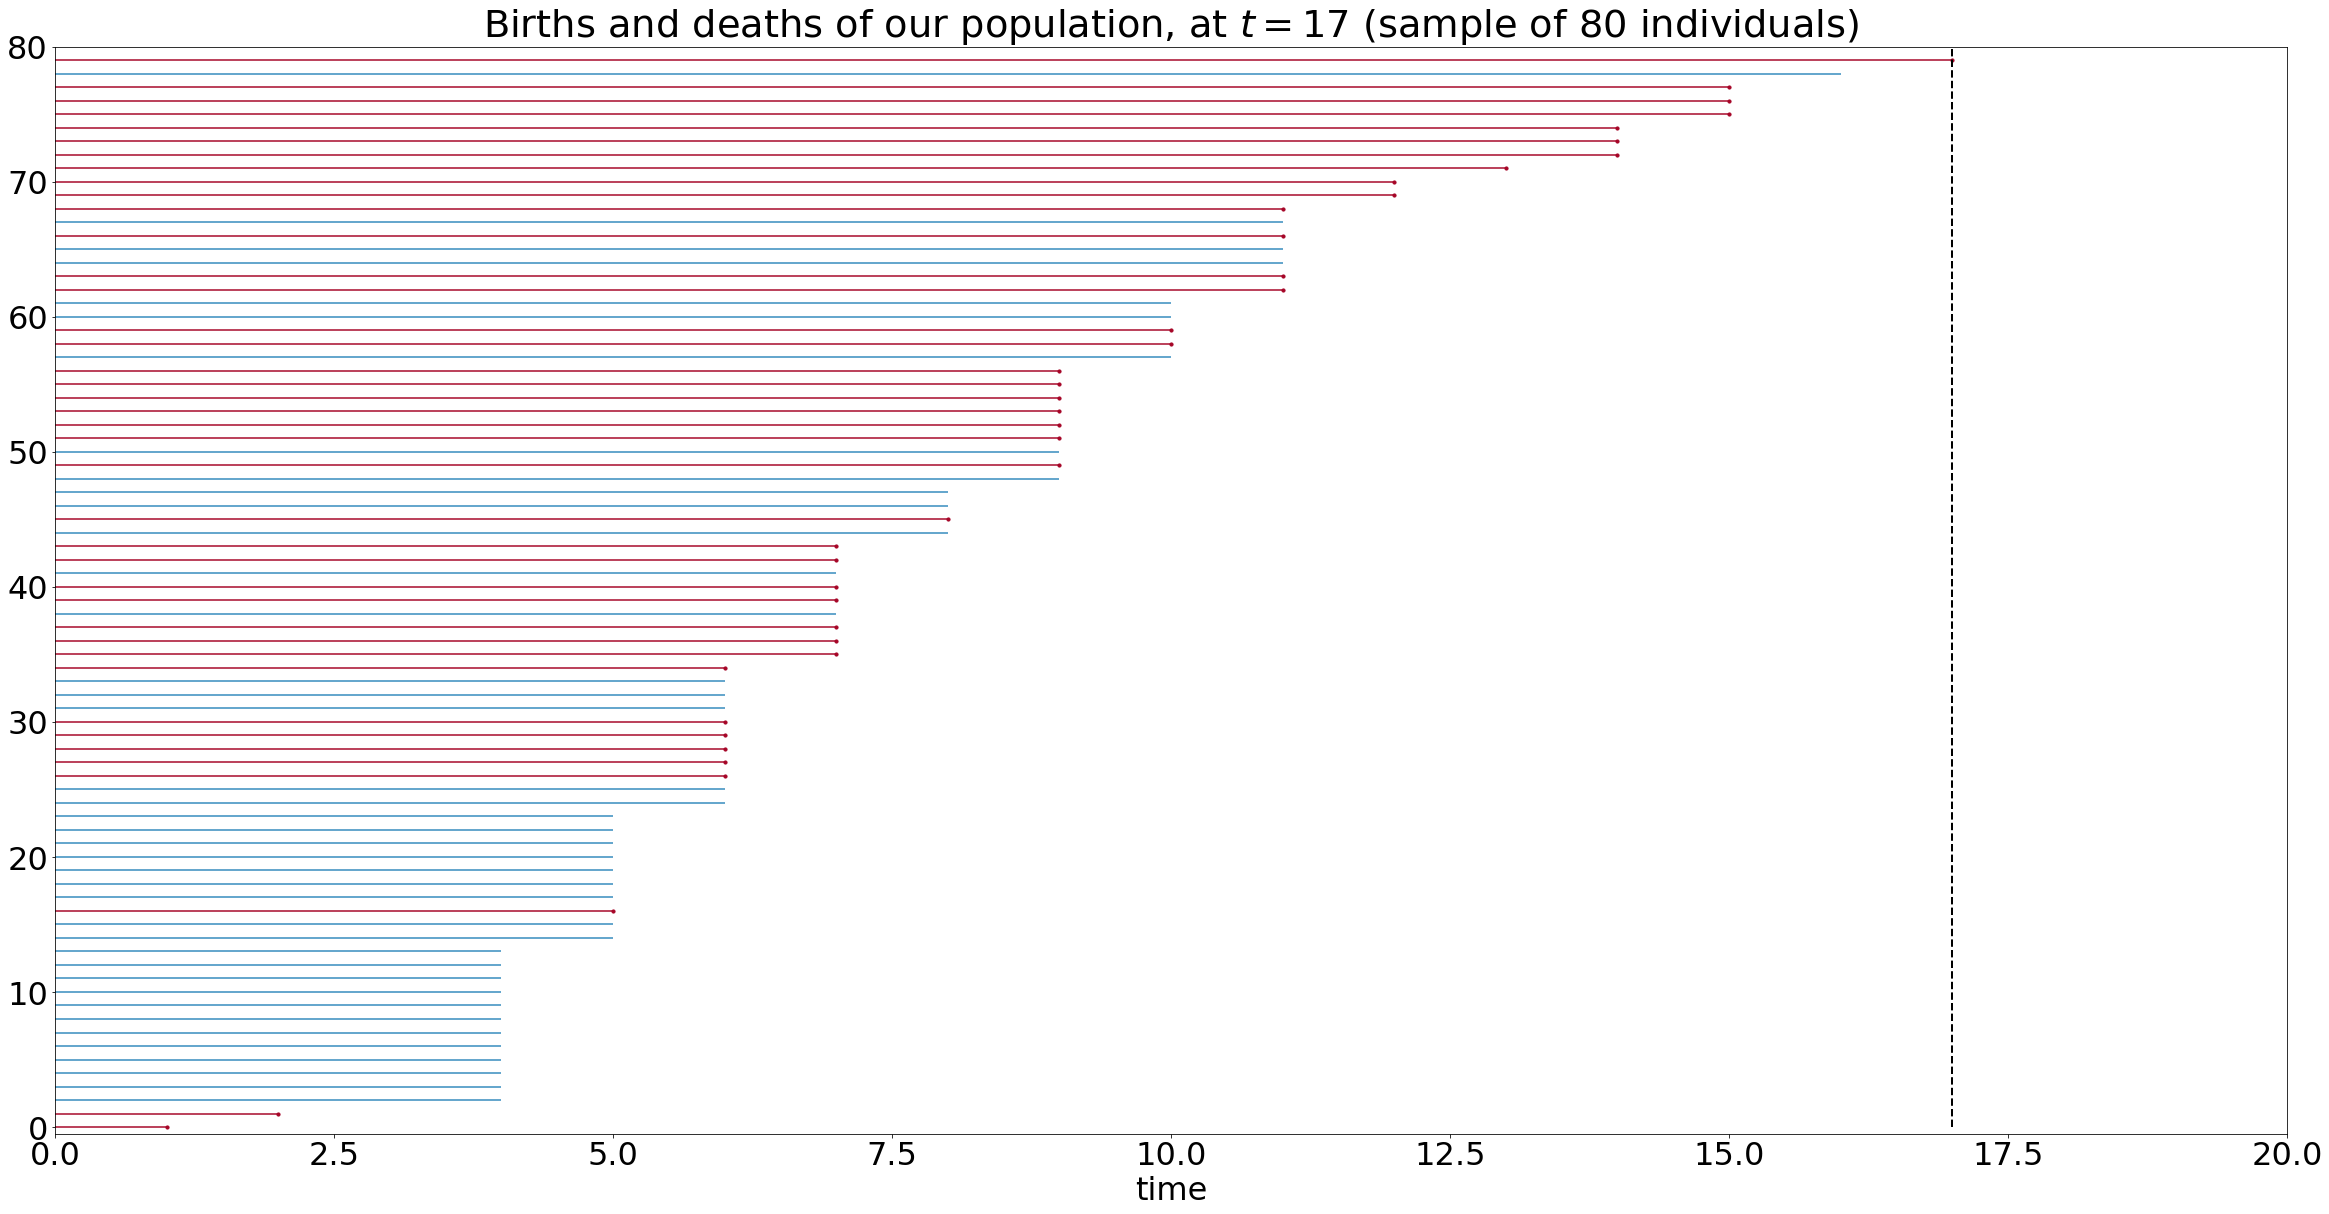

In [17]:
np.random.seed(42) # Just for repoducibility
indexes = np.random.choice(len(age_censor_df), 80, replace=False)

ax = plot_lifetimes(age_censor_df.iloc[indexes].age, event_observed=age_censor_df.iloc[indexes].censored)

ax.set_xlim(0, 20)
ax.vlines(CURRENT_TIME, 0, 80, lw=2, linestyles='--')
ax.set_xlabel("time")
_=ax.set_title("Births and deaths of our population, at $t={}$ (sample of {} individuals)".format(CURRENT_TIME, len(indexes)))

#### Let's now estimate the survival function using Kaplan-Meier

In [18]:
kmf = KaplanMeierFitter()

In [19]:
kmf.fit(age_censor_df.age, event_observed=age_censor_df.censored)

/Users/maccheroni/.virtualenvs/sandbox/lib/python3.7/site-packages/lifelines/utils/__init__.py:1172: UserWarning: Attempting to convert an unexpected datatype 'object' to float. Suggestion: 1) use `lifelines.utils.datetimes_to_durations` to do conversions or 2) manually convert to floats/booleans.
  warnings.warn(warning_text, UserWarning)


<lifelines.KaplanMeierFitter:"KM_estimate", fitted with 18529 total observations, 7911 right-censored observations>

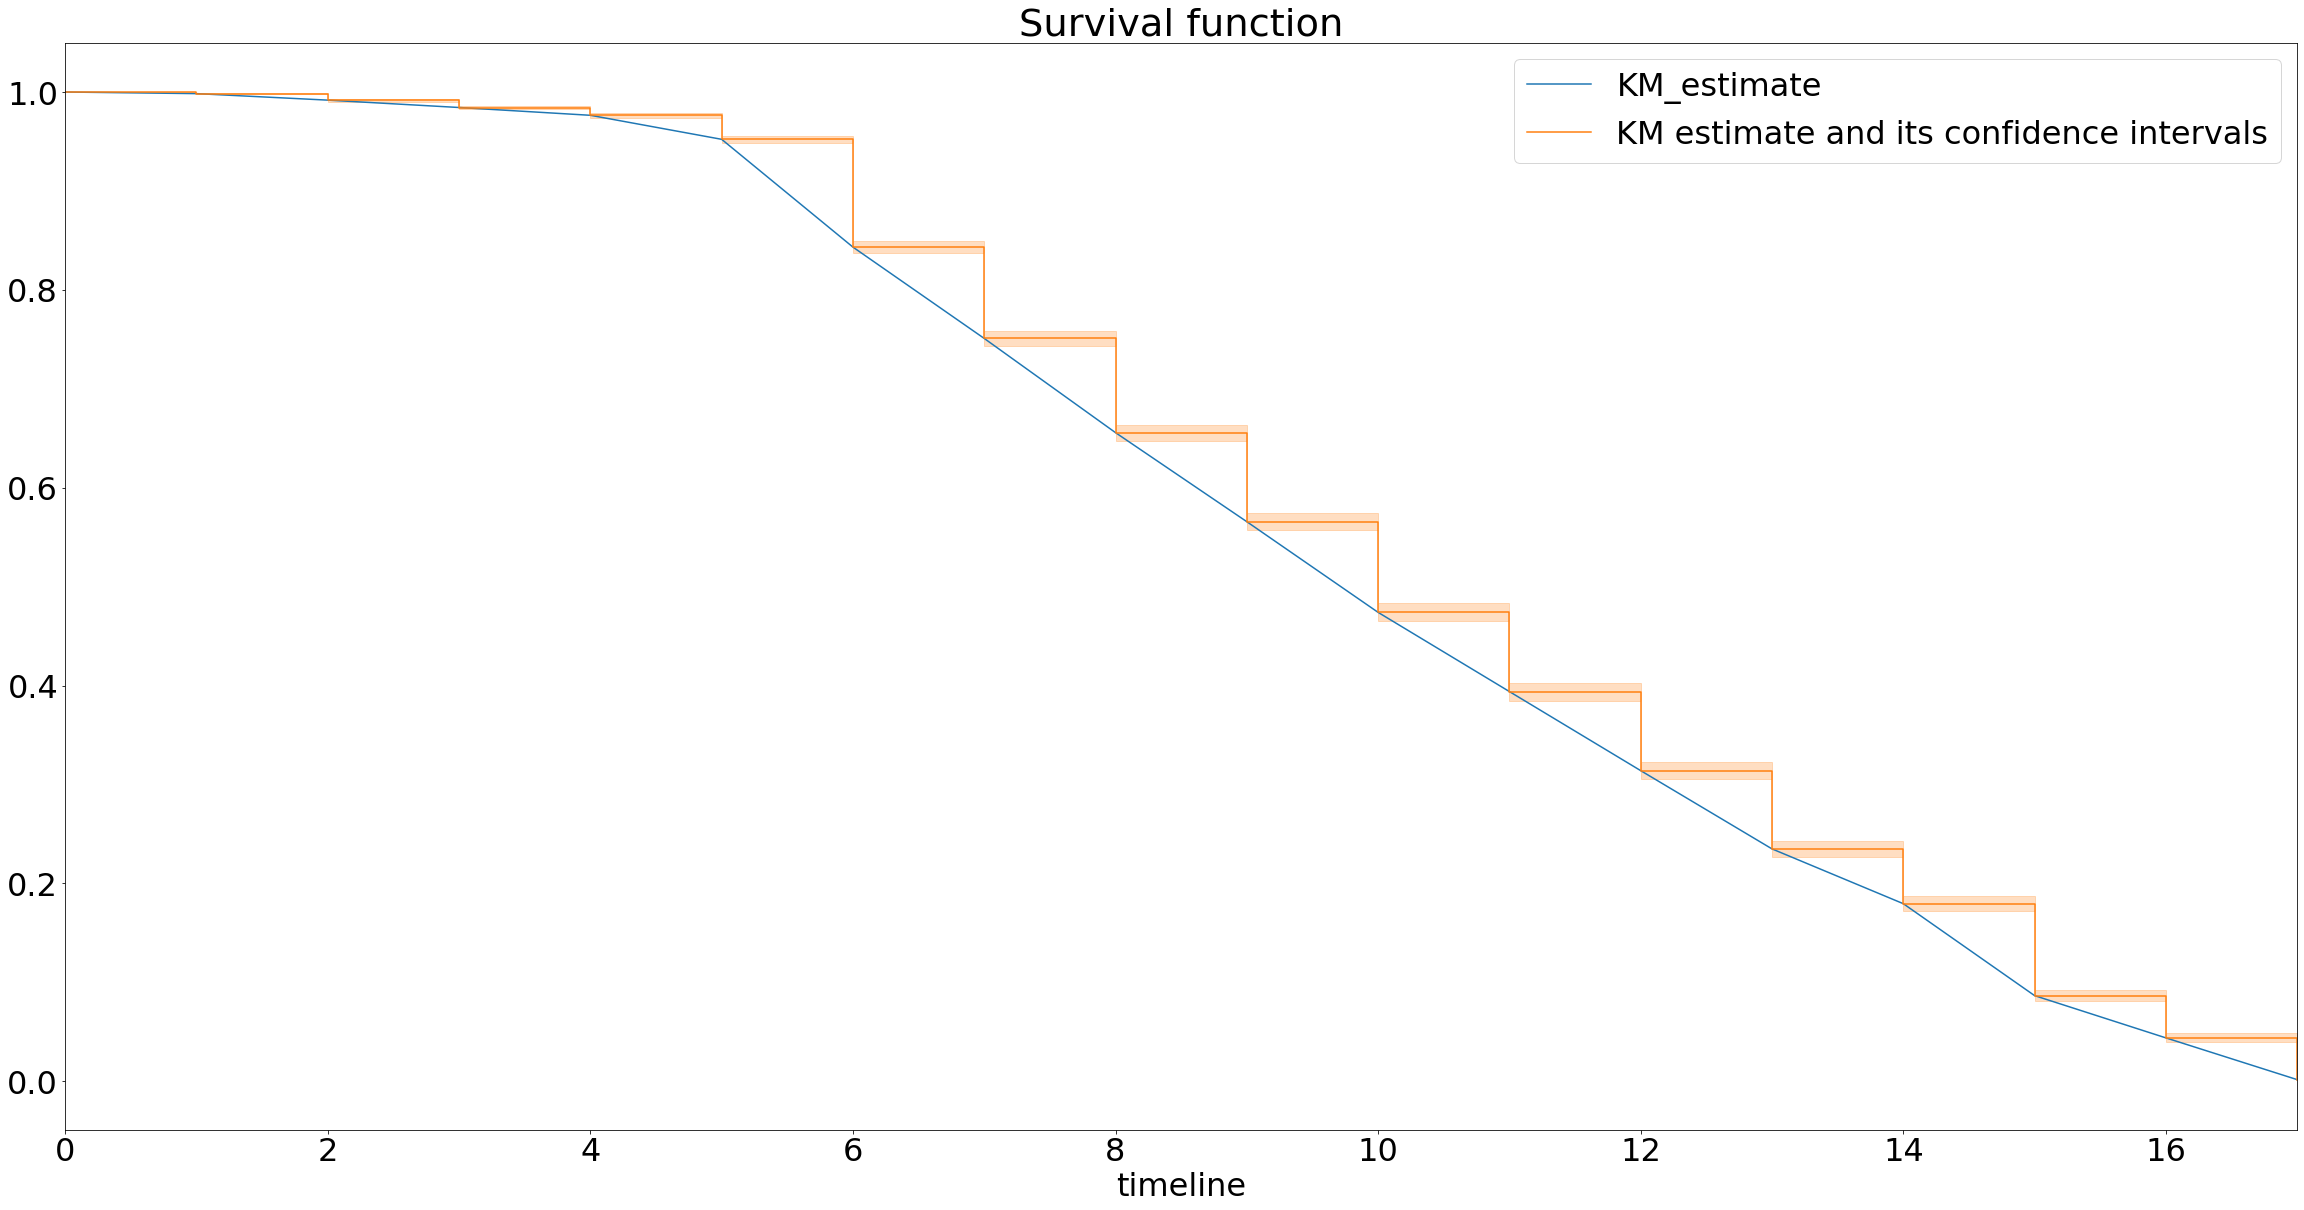

In [20]:
fig, ax = plt.subplots()
kmf.survival_function_.plot(ax=ax, label="Survival function")
kmf.plot(ax=ax, label="KM estimate and its confidence intervals")
plt.title('Survival function')
plt.show()

The y-axis represents the probability a user is still around after 𝑡 months, where 𝑡 months is on the x-axis. We see that vast majority of users remains for at least 5 months. Few users stays more than 15 months, but considering that the maximum observerd lifespan is 17 months this is a very good retention rate. The  confidence intervals shown in the graph above are computed in the call to fit(), and located under the confidence_interval_ property. (The method uses exponential Greenwood confidence interval. The mathematics are found in [these notes](https://www.math.wustl.edu/~sawyer/handouts/greenwood.pdf).) 

**The median time of the app, which defines the point in time where on average 50% of the population has expired, is:**

In [21]:
print("MEDIAN SURVIVAL TIME: {}".format(kmf.median_survival_time_))

MEDIAN SURVIVAL TIME: 10.0


This means that the average user lifespan is 10 months. 50% of the population will be churned after 10 months. A naive approach would be to decide a percentile, let's say 95% percentile, and do some action to avoid churn after that. But this a too simplistic approach. In the next notebook I use something more elaborated.

### MEDIAN SURVIVAL RATES BY FEATURES
I will now look at average survival by various type of features.

In [22]:
# Checking that there is only one device associated to each user
device_count = devices.groupby("user_id").size()
max(device_count)

1

In [23]:
user_age_device = pd.merge(age_censor_df, devices, left_index=True, right_on="user_id")
android_users = user_age_device[user_age_device.brand=="Android"]
apple_users = user_age_device[user_age_device.brand=="Apple"]

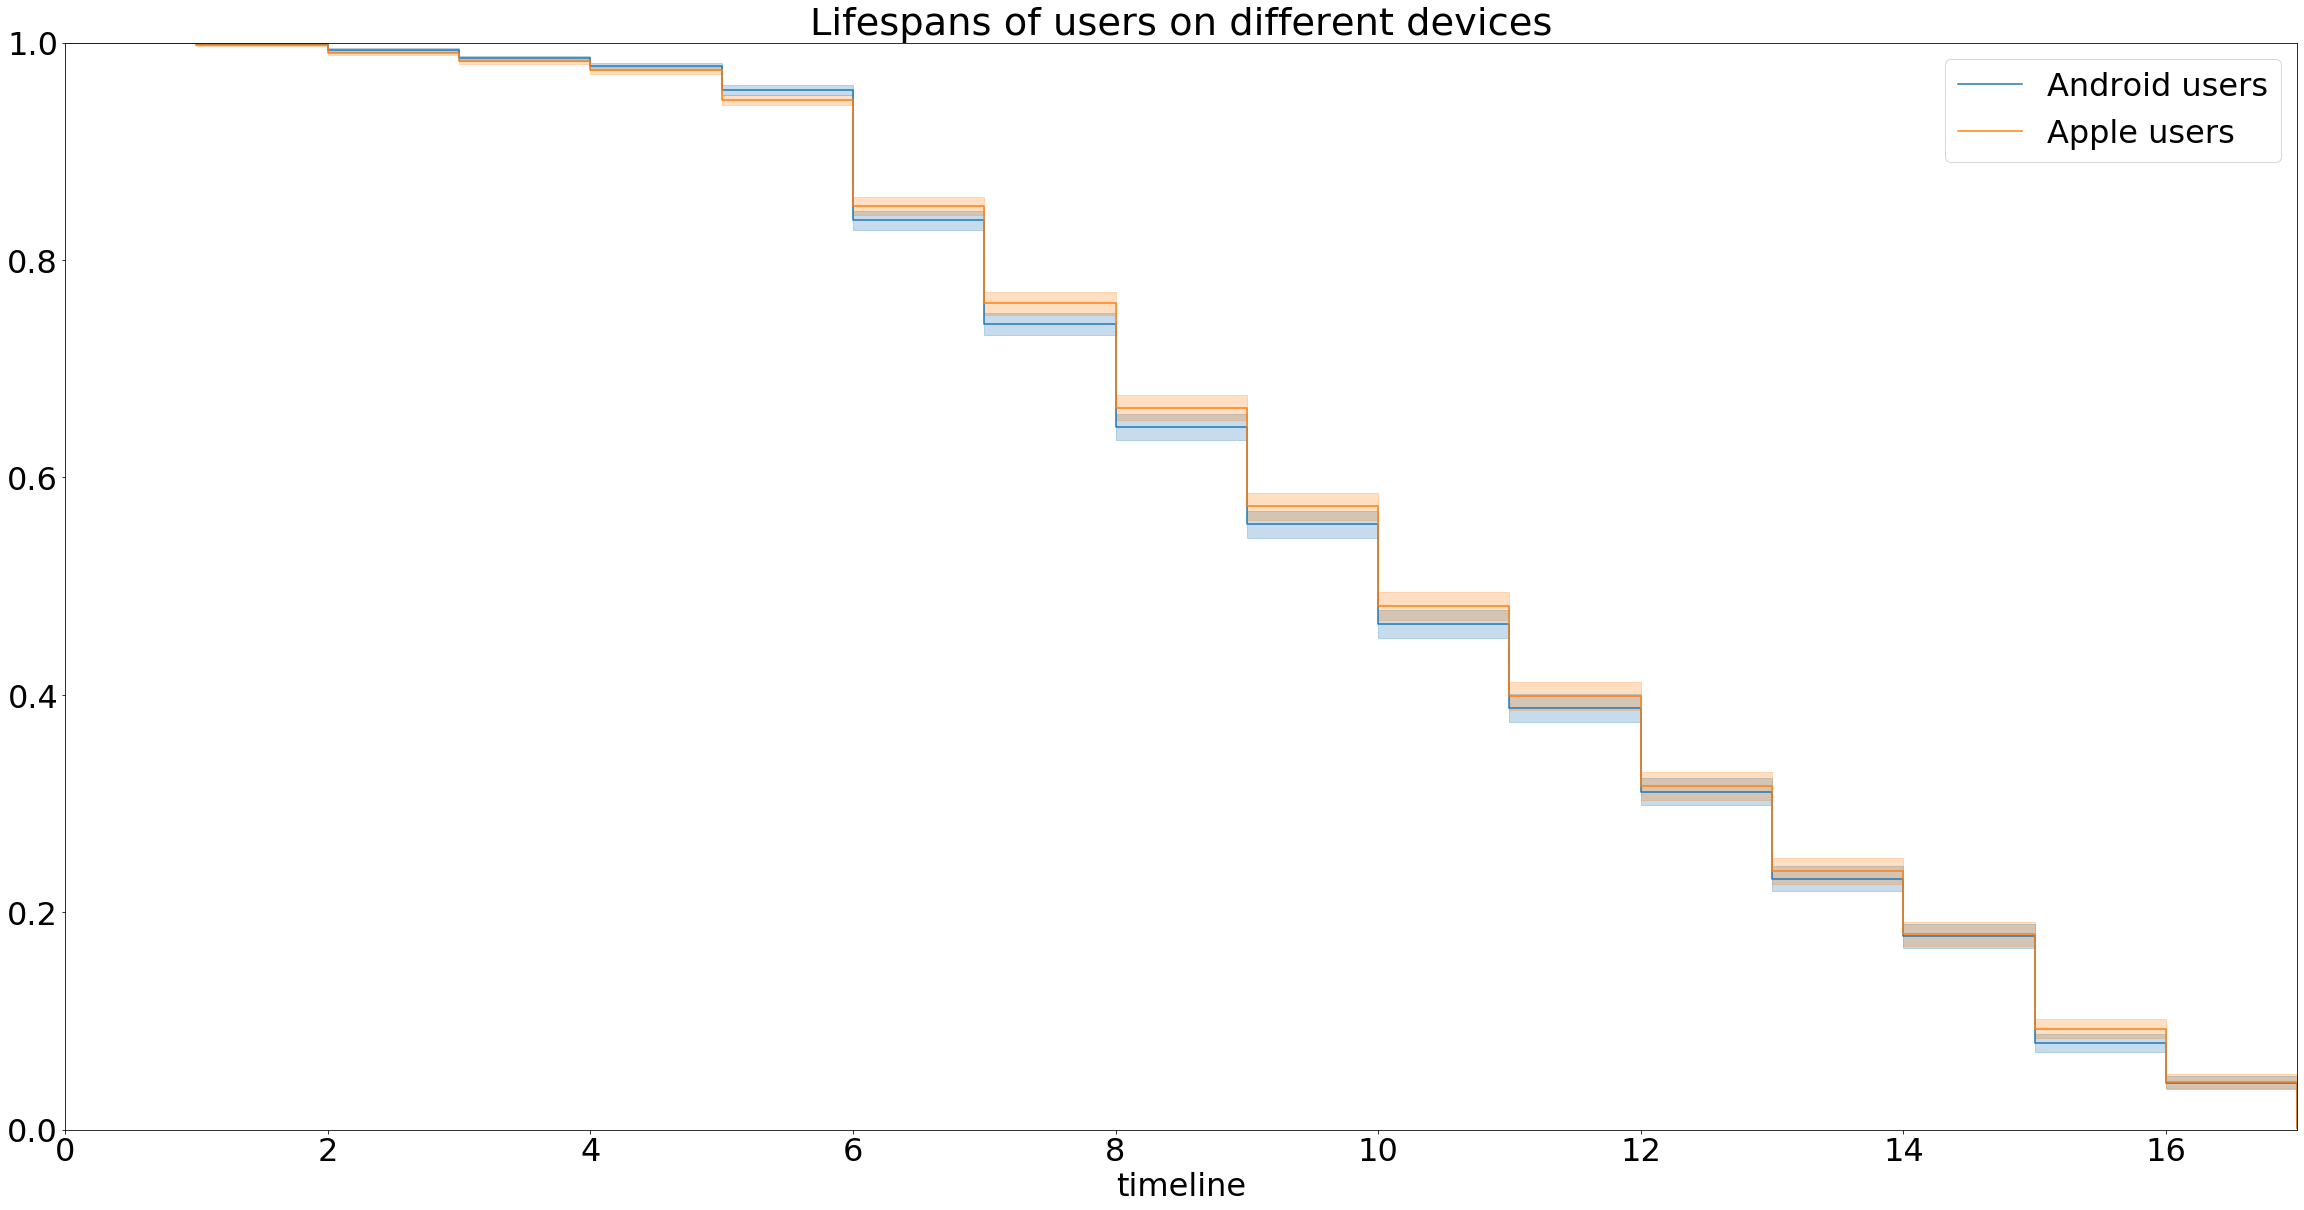

In [24]:
ax = plt.subplot(111)

kmf.fit(android_users.age, event_observed=android_users.censored, label="Android users")
kmf.plot(ax=ax)

kmf.fit(apple_users.age, event_observed=apple_users.censored, label="Apple users")
kmf.plot(ax=ax)

plt.ylim(0, 1);
plt.title("Lifespans of users on different devices");

They look very close so there is very likely not statistical difference.

In [25]:
user_age_country = pd.merge(age_censor_df, users, left_index=True, right_on="user_id")[['user_id', 'country', 'birth_year', 'age', 'censored']]

#### Lifespan by country

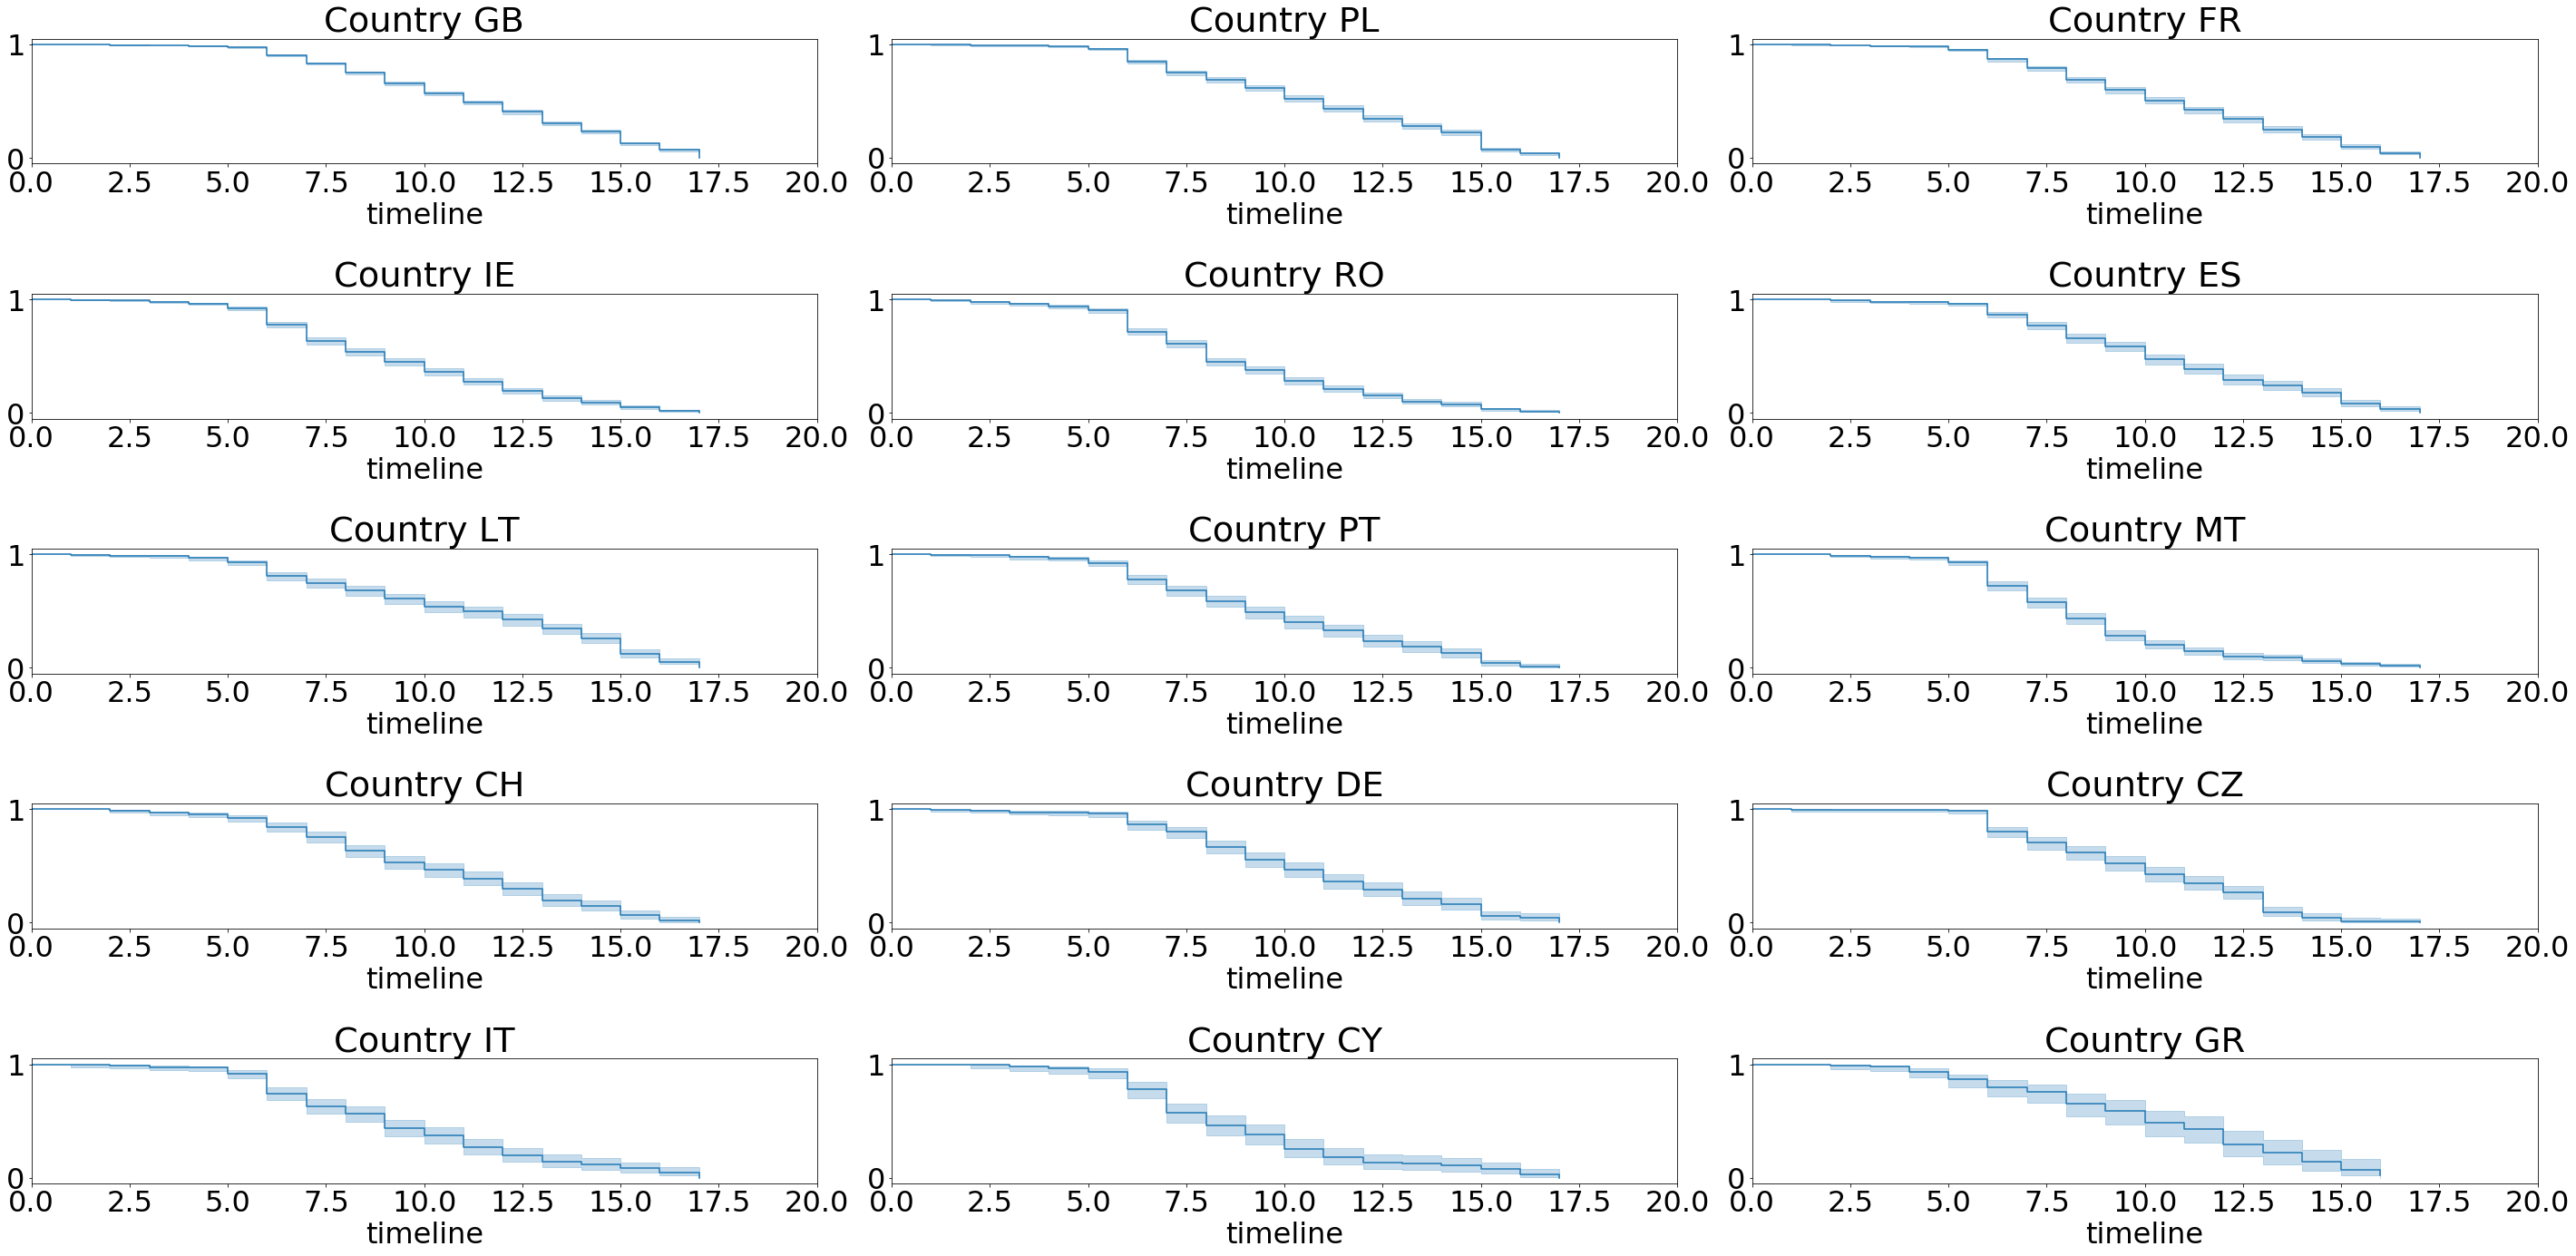

In [26]:
ax = plt.subplot(111)

most_common_countries = user_age_country.groupby('country').size().sort_values(ascending=False).iloc[0:15].index

for i, country in enumerate(most_common_countries):
    ax = plt.subplot(5, 3, i + 1)
    
    temp = user_age_country[user_age_country.country == country]
    
    kmf.fit(temp.age, event_observed=temp.censored, label="Country {}".format(country))
    kmf.plot(ax=ax, legend=False)

    plt.title("Country {}".format(country))
    plt.xlim(0, 20)

plt.tight_layout()

### Lifespan by age group

In [27]:
user_age_country["user_age"] = max(transactions.created_date.dt.year) - user_age_country.birth_year
user_age_country['age_group'] = pd.cut(user_age_country.user_age, 4)

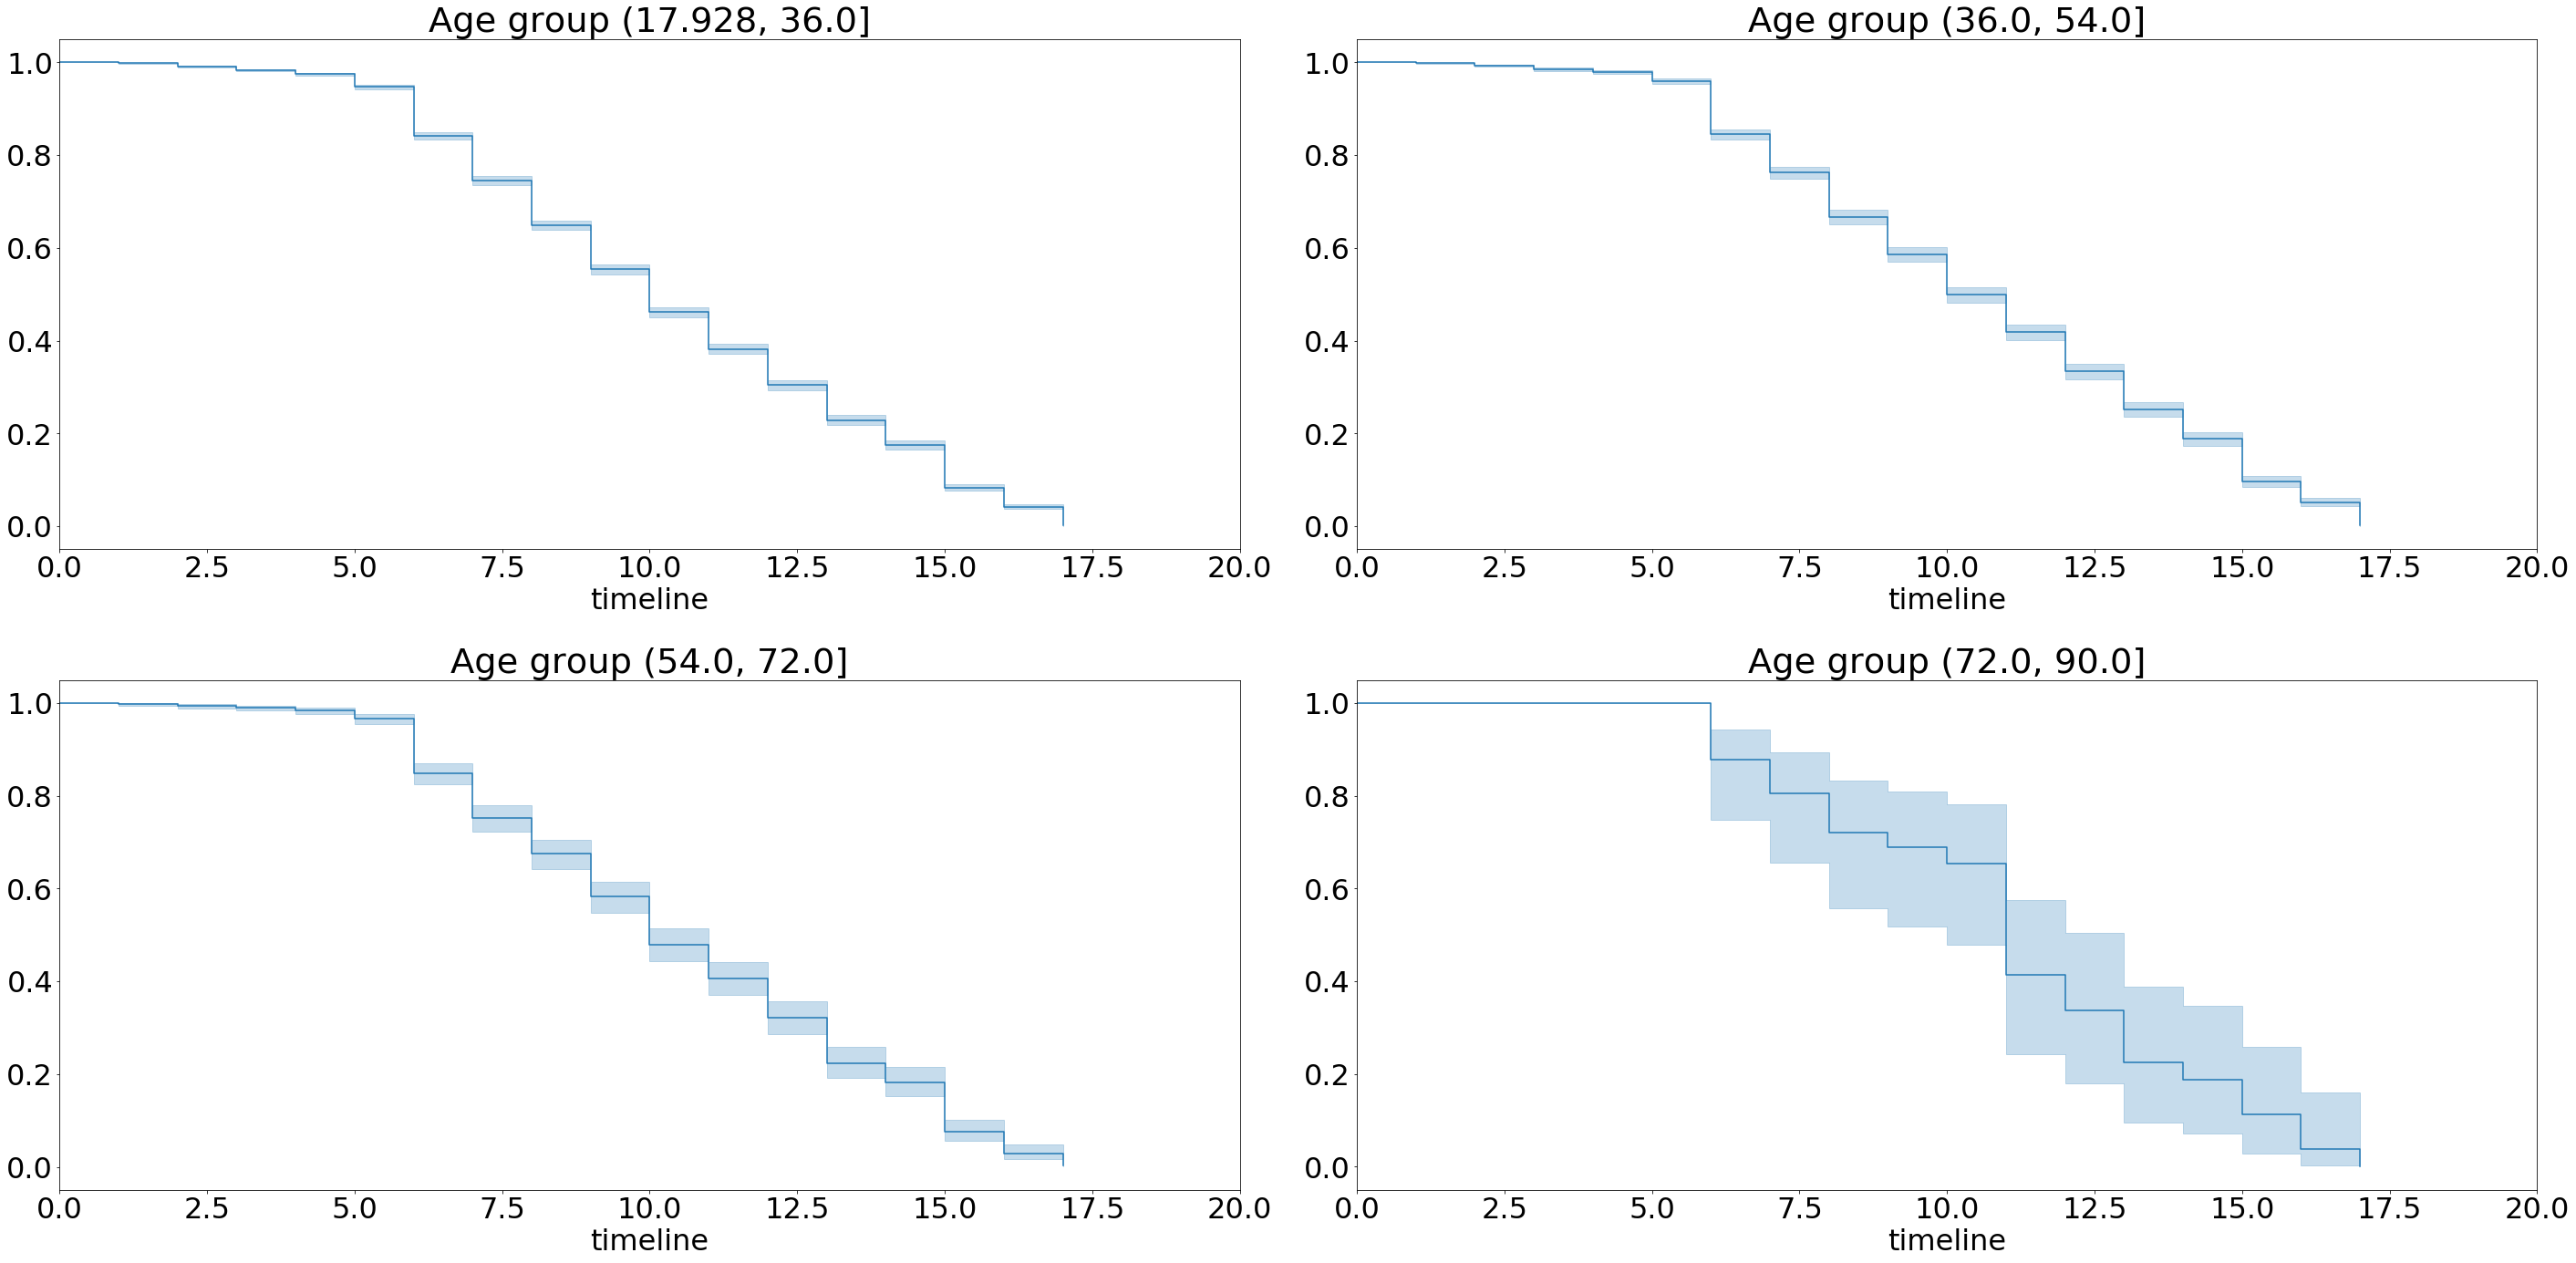

In [28]:
age_groups = user_age_country.age_group.unique()

ax = plt.subplot(111)

for i, age_group in enumerate(age_groups):
    ax = plt.subplot(2, 2, i + 1)
    
    temp = user_age_country[user_age_country.age_group == age_group]
    
    kmf.fit(temp.age, event_observed=temp.censored, label="Age group {}".format(country))
    kmf.plot(ax=ax, legend=False)

    plt.title("Age group {}".format(age_group))
    plt.xlim(0, 20)

plt.tight_layout()

The Kaplan-Meier survival anlysis on both age group and country didn't produce noticable effect or result. For this reason, using a survival model based on univariate modelling for predicting churn doesn't seem promising. Instead, in order to predict churn I will use a classifier that will try to predict if a user will churn in the next 3 months.

### Lifespan by cohoort

In [29]:
cohort_df = users[['user_id', 'created_date']]
cohort_df.created_date = pd.to_datetime(cohort_df.created_date).dt.strftime('%Y-%m')

user_cohoort = pd.merge(age_censor_df.reset_index(), cohort_df, left_on="user_id", right_on="user_id")

/Users/maccheroni/.virtualenvs/sandbox/lib/python3.7/site-packages/pandas/core/generic.py:5208: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


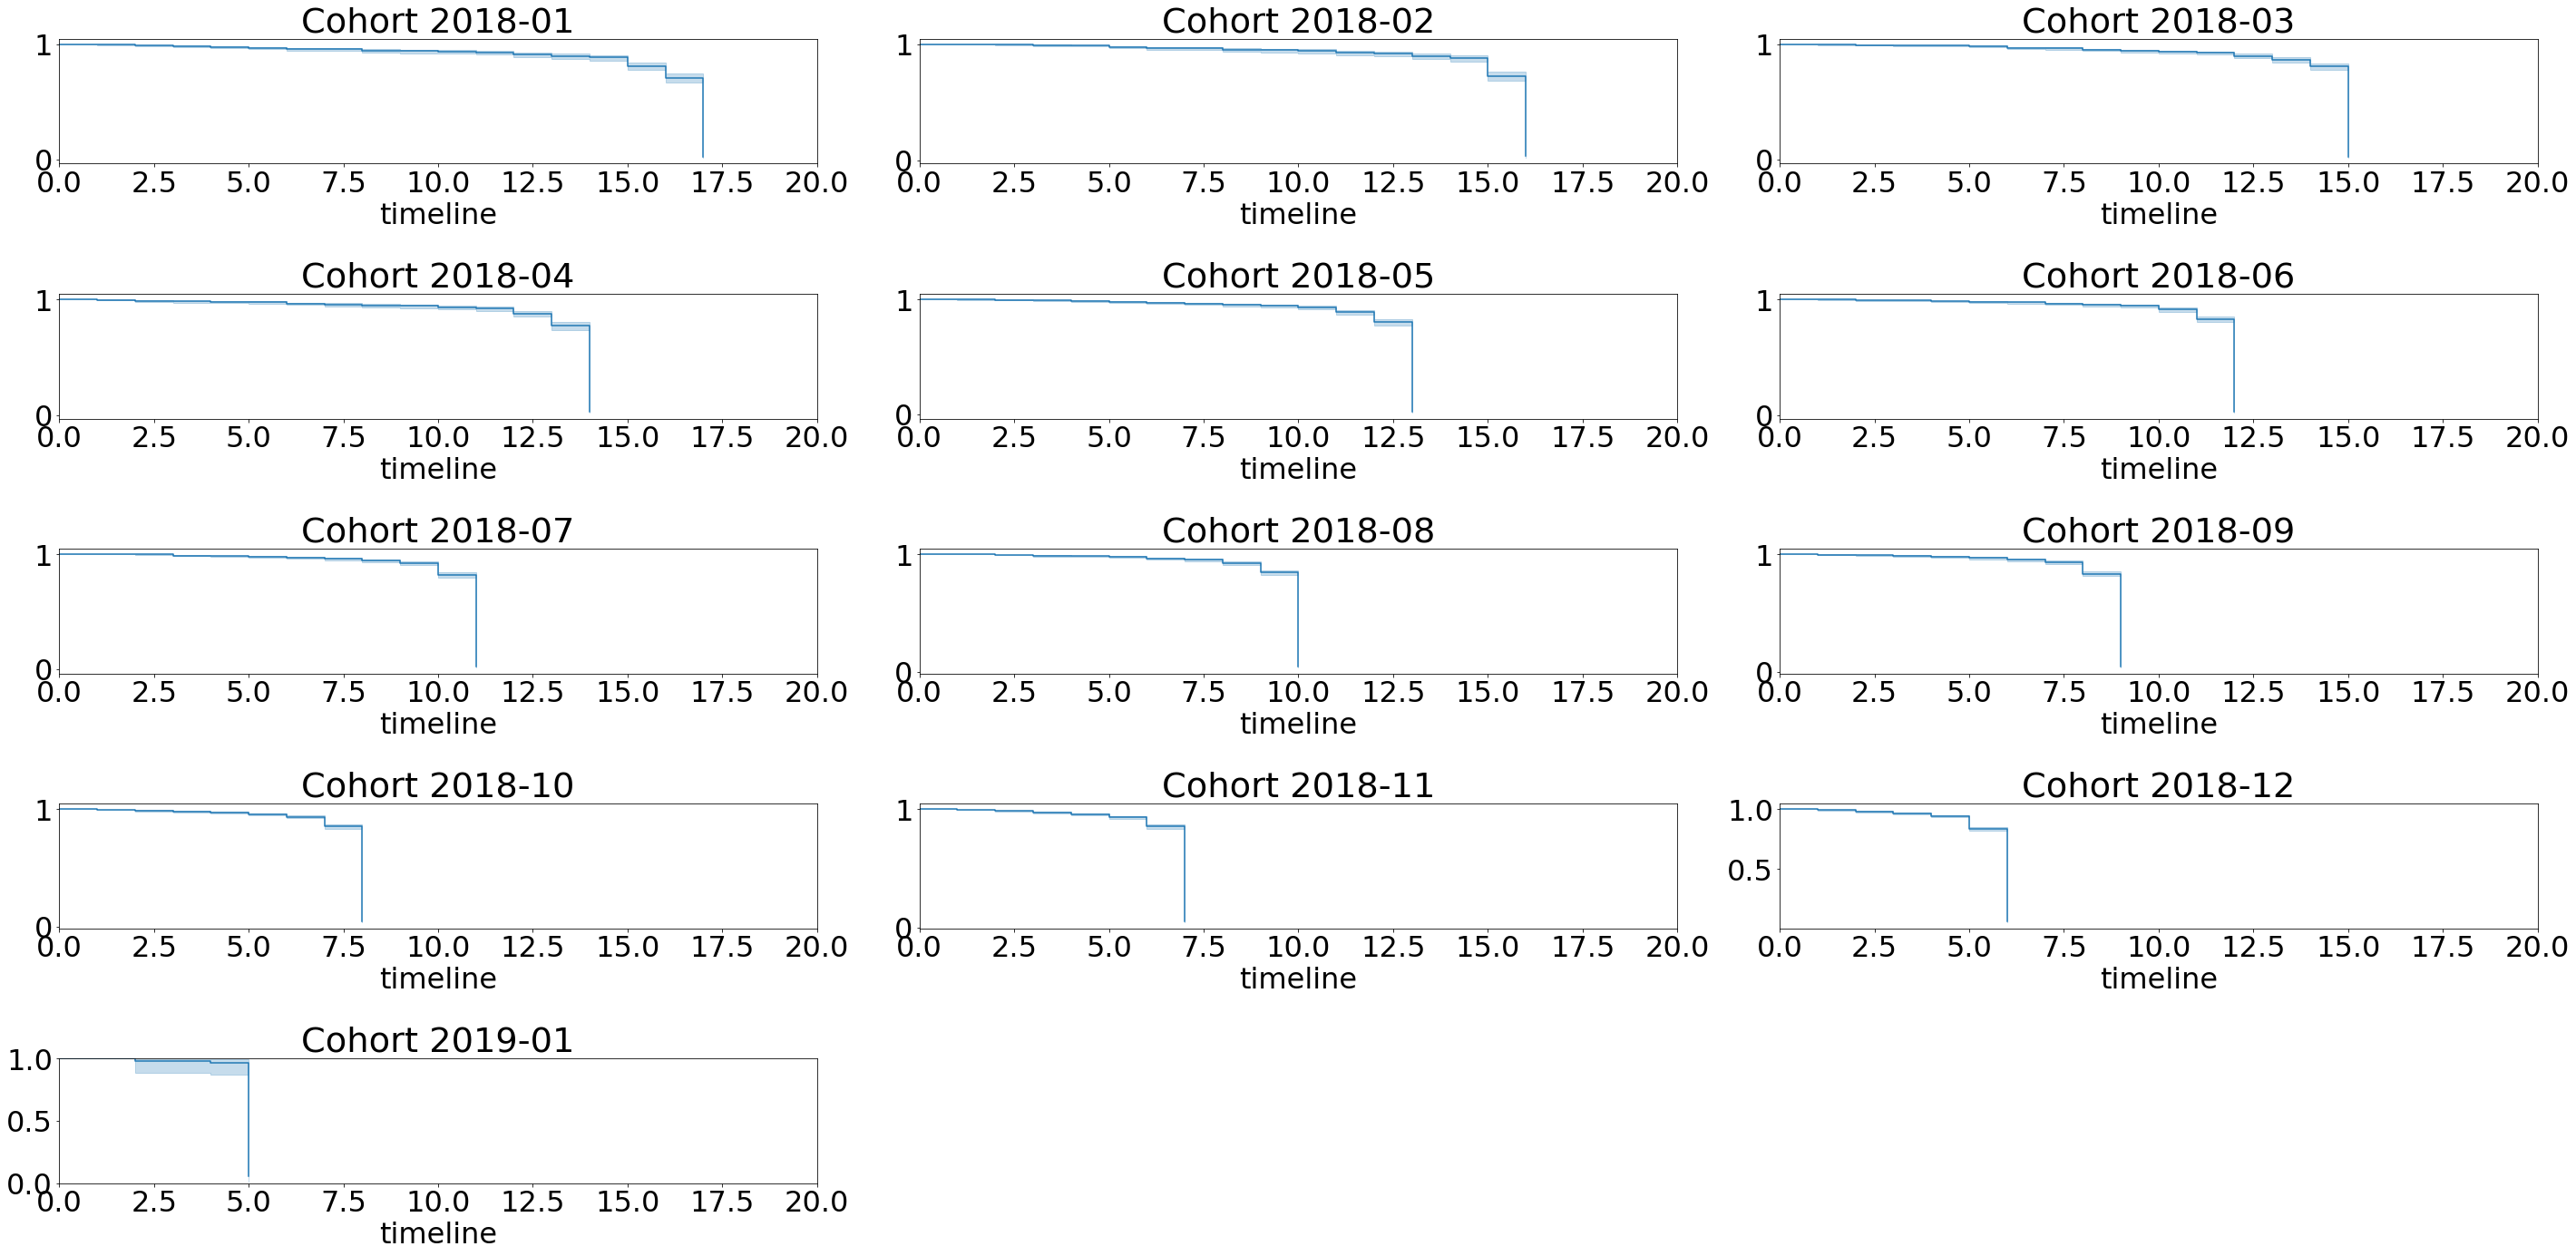

In [34]:
ax = plt.subplot(111)

for i, cohoort in enumerate(sorted(user_cohoort.created_date.unique())):
    
    ax = plt.subplot(5, 3, i + 1)
    
    tmp=user_cohoort[user_cohoort.created_date == cohoort]
    kmf.fit(tmp.age, event_observed=tmp.censored)
    kmf.plot(ax=ax, legend=False)

    plt.title(f"Cohort {cohoort}")
    plt.xlim(0, 20)


    

del tmp
plt.ylim(0, 1);
# plt.title("Lifespans by users cohoort");
plt.tight_layout()

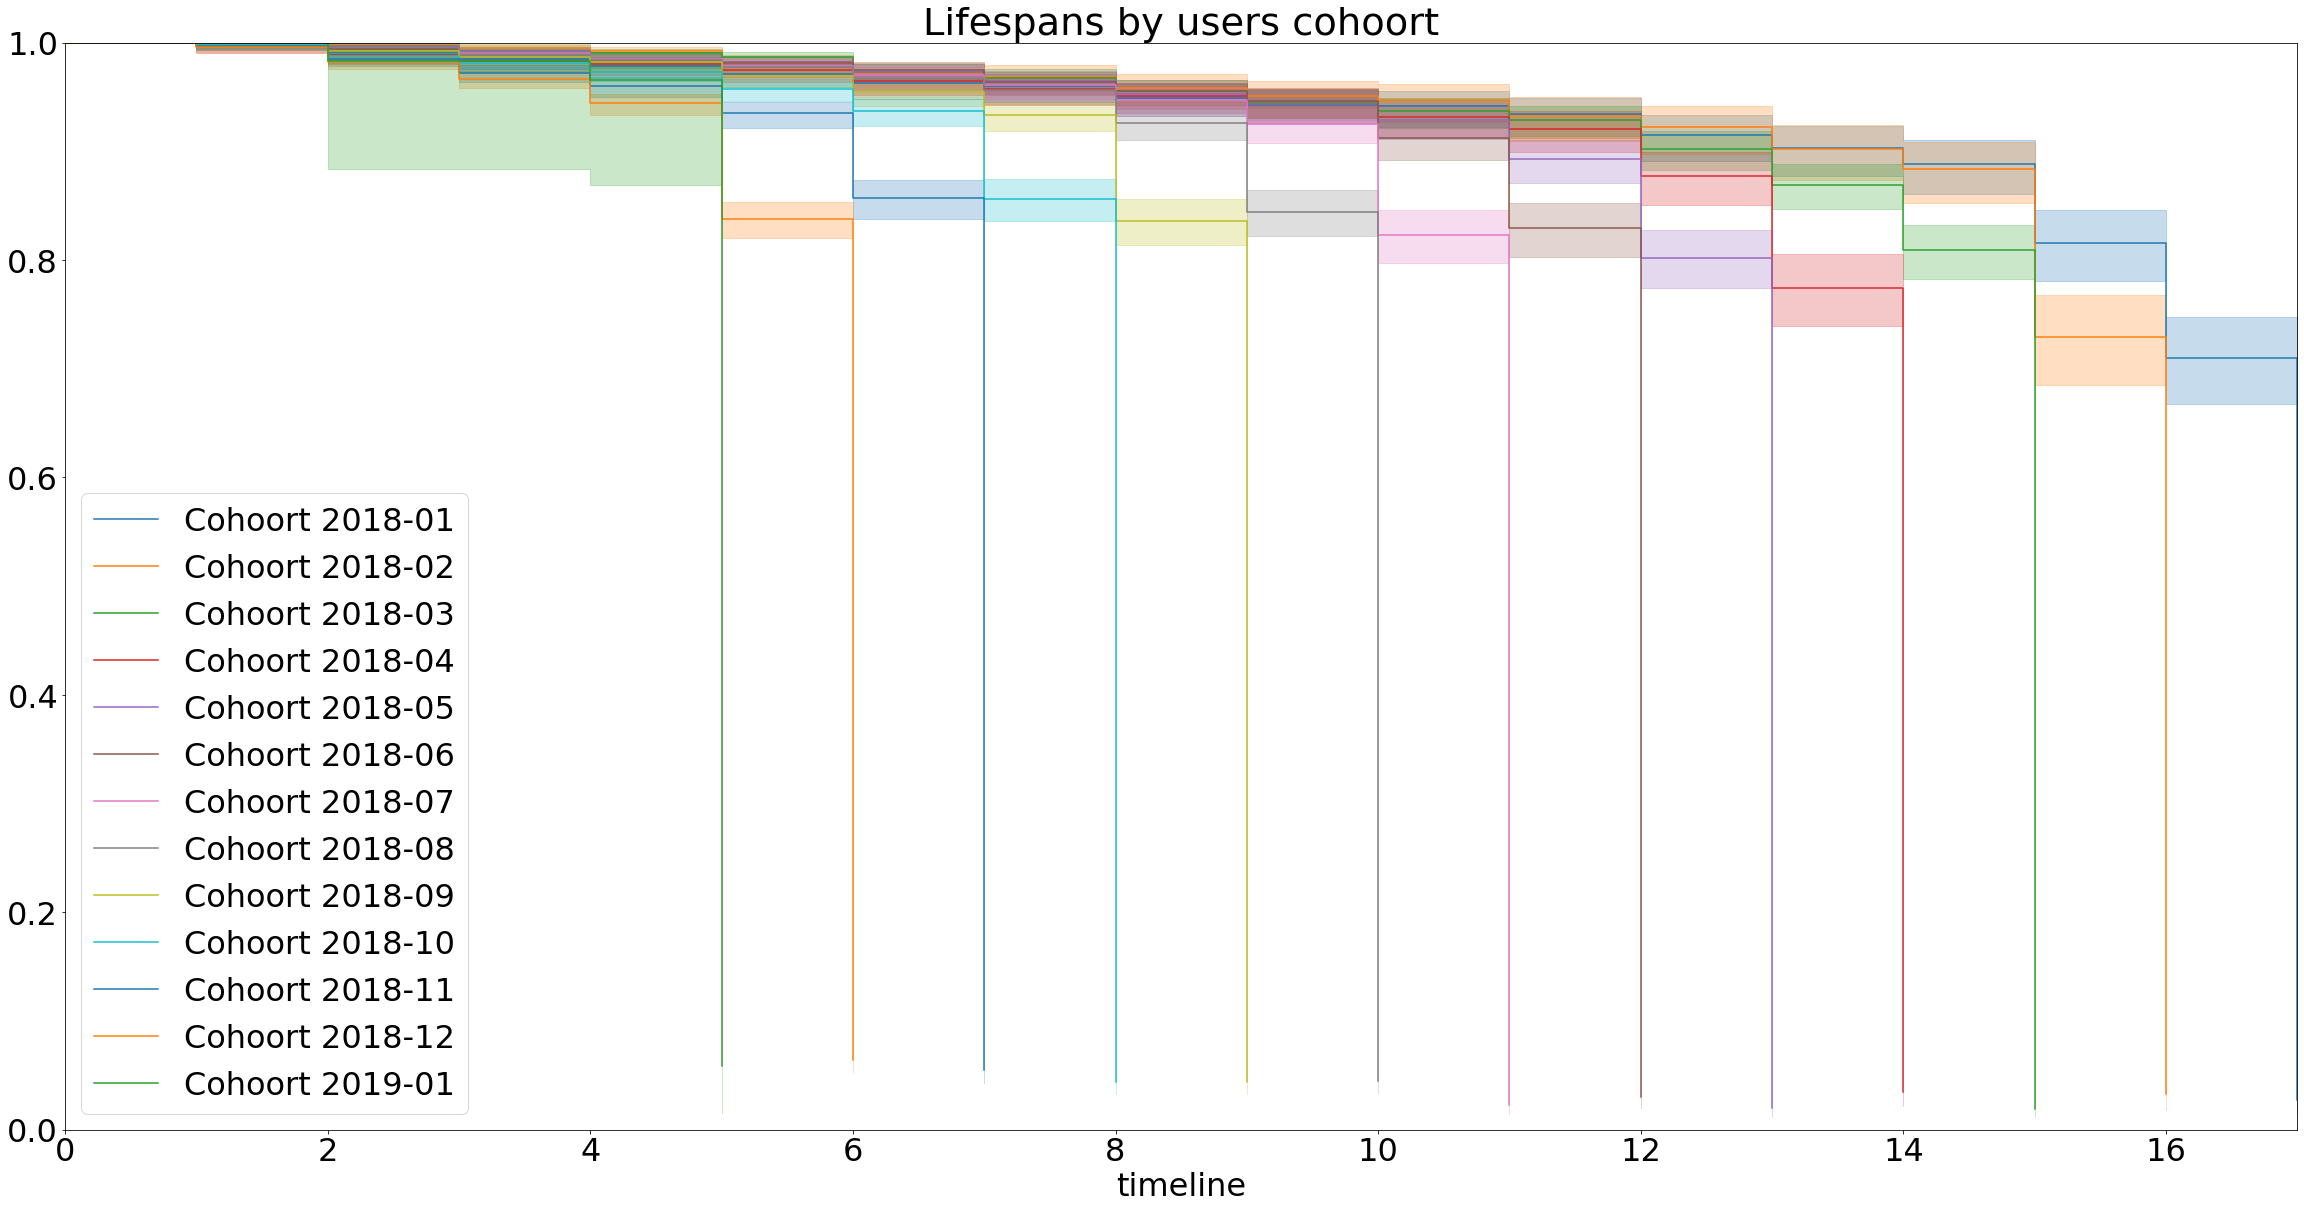

In [32]:
ax = plt.subplot(111)
median_survial_times = {}

for cohoort in sorted(user_cohoort.created_date.unique()):
    
    tmp=user_cohoort[user_cohoort.created_date == cohoort]
    kmf.fit(tmp.age, event_observed=tmp.censored, label=f"Cohort {cohoort}")
    kmf.plot(ax=ax)
    median_survial_times[cohoort] = kmf.median_survival_time_

# del tmp
plt.ylim(0, 1);
plt.title("Lifespans by users cohort");

In [33]:
median_survial_times

{'2018-01': 17.0,
 '2018-02': 16.0,
 '2018-03': 15.0,
 '2018-04': 14.0,
 '2018-05': 13.0,
 '2018-06': 12.0,
 '2018-07': 11.0,
 '2018-08': 10.0,
 '2018-09': 9.0,
 '2018-10': 8.0,
 '2018-11': 7.0,
 '2018-12': 6.0,
 '2019-01': 5.0}

## 4 - Preparing the data for churn predicting
In order to predict churn we need first to transform our dataset and create some features. The rest of this notebook is dedicated to this step, data preparation. The next notebook is where the actual modelling happens. What we will be trying to predict (the target variable) will be if an **user will churn in the next 3 months**. I will be using a 3 months rolling window to create multiple data points in the dataset for each user. For example, if a user has 12 months of activity before churning, it will generate 12-3-3 = 6 data points. The first 3 months are the cooling period (period necessary to collect some data), the second 3 months subtraction are to allow enough time to verify the target outcome for month 9th. After the first 3 months, it will generate one data point `not churning` , same on the 4th and so on until the 9th, when it will have `churning` as target (if the remaining 3 months have zero activity). Let's first create this target variable.

**NOTE**: In constructing the dataset, I will stop at looking at the user history as soon as I meet 3 months withouth activity. I will consider churned any user that do not have any activity for 3 months (excluding cooling period), even if later has activities again. Assuming that I am sitting at time `t`, and my classifier tells me that the user will churn starting at `t+1`, and at `t+3` the user haven't done any activity I will probably consider the user effectivelty churned, I won't probably see what the user will do at `t+4` or more.

First I need to find last time when the user has had an activity. For this we can start from `user_transactions` data frame as it already contains some useful aggregations.

In [29]:
tmp = user_transactions.copy()
# tmp['rank'] = tmp.groupby("user_id")['date'].rank()

users_ids = tmp.user_id.unique()

target_df = []
COOLING_PERIOD = 3 # I am not looking at inactivity before a minimum time frame expressed by this variable (in months)

for uid in users_ids:
    series = tmp[tmp.user_id == uid]
    number_of_batches = len(series)-2
    for i in range(COOLING_PERIOD, number_of_batches):
        current_batch = series.iloc[i:i+3,:]
        if current_batch['transaction_count'].sum() != 0:
            target_df.append((uid, series.iloc[i-1]['date'], "not churned"))
        if current_batch['transaction_count'].sum() == 0:
            target_df.append((uid, series.iloc[i-1]['date'], "churned"))
            break
    

target_df = pd.DataFrame(target_df, columns=['user_id', 'date' , 'target'])
del tmp

OKAY, now that we have the targets, we can start building some features!

### FEATURE BUILDING

 #### Transaction based features
 In this section I will build some feature using the transactions table. 
 The features that I will build are of three types:
 - 3 months triangular rolling averages: Based on a 3 months rolling window, calculate as 3 months triangluar rolling average.
 - Cumulative sum: Tot sum since user registration.
 - Cumulative max: Max value since user registration.
 
Below there are more details for each feature.

I could have build 6 month, 9 months rolling window feratures, but thery would have been higly correlated with each other, and therefore I prefered not to include them.
 
 This operation will take few miniutes (5 minutes approx).

In [30]:
completed_transactions = transactions[transactions.transactions_state == 'COMPLETED']

### AMOUNT FEATURES
print("Building amount based feature...")
temp = completed_transactions.set_index('created_date')\
            .groupby(['user_id', pd.Grouper(freq="M"), "direction", "transactions_type"])\
            .agg({'amount_usd':['mean', 'size']})\
            .unstack(level=[-1, 0])

temp = temp.dropna(axis='columns', how='all') # Drop NaN only columns
temp.columns = temp.columns.droplevel()

mean_transactions = temp.fillna(0).loc[:, ('mean')].groupby('user_id').rolling(3, win_type='triang').mean()
sum_count_transactions = temp.fillna(0).loc[:, ('size')].groupby('user_id').rolling(3, win_type='triang').sum()
del temp

mean_transactions.columns = ['_'.join(col).strip() for col in mean_transactions.columns.values]
sum_count_transactions.columns = ['_'.join(col).strip() for col in sum_count_transactions.columns.values]

mean_transactions = mean_transactions.droplevel(0)
sum_count_transactions = sum_count_transactions.droplevel(0)

transactions_features_df = pd.merge(mean_transactions, sum_count_transactions, right_index=True, left_index=True, how='outer', suffixes=["_MEAN", "_SUM"])
transactions_features_df = transactions_features_df.dropna(how='all')

### CURRENCY FEATURE
print("Building currency feature...")
currency_used = completed_transactions.set_index('created_date')\
                    .groupby(['user_id', pd.Grouper(freq="M")])['transactions_currency'].unique().apply(len)

currency_used = currency_used.groupby('user_id').cummax()
currency_used = currency_used.dropna().rename("currencies_used")

transactions_features_df = pd.merge(transactions_features_df, currency_used, right_index=True, left_index=True, how='left')

### MERCHANT CITY FEATURE
print("Building merhcant city feature...")
merchant_city = completed_transactions.set_index('created_date')\
                    .groupby(['user_id', pd.Grouper(freq="M")])['ea_merchant_city'].unique().apply(len)

merchant_city = merchant_city.groupby('user_id').cummax()
merchant_city = merchant_city.rename("tot_merchant_city")

transactions_features_df = pd.merge(transactions_features_df, merchant_city, right_index=True, left_index=True, how='left')


### TRIANGULAR ROLLING SUM OF FAILED TRANSACTION IN THE LAST 3 MONTHS
print("Building failed transaction feature...")
failed_transaction = transactions[transactions.transactions_state.isin(['REVERTED', 'DECLINED', 'FAILED', 'CANCELLED'])].set_index('created_date')\
                    .groupby(['user_id', pd.Grouper(freq="M")]).size()

failed_transaction = failed_transaction.groupby('user_id').rolling(3, win_type='triang').sum()
failed_transaction = failed_transaction.droplevel(0).rename("tot_error_transactions")
transactions_features_df = pd.merge(transactions_features_df, failed_transaction, right_index=True, left_index=True, how='left')


### `tot_online_transactions` TOT ONLINE TRANSACTIONS FEATURE
print("Building online transaction feature...")
online_transactions = completed_transactions[np.logical_not(completed_transactions.ea_cardholderpresence.map({"TRUE": True, "FALSE": False, "NaN":True}).astype(bool))].set_index('created_date')\
                    .groupby(['user_id', pd.Grouper(freq="M")]).size()

online_transactions = online_transactions.groupby('user_id').rolling(3, win_type='triang').mean()
online_transactions = online_transactions.droplevel(0).rename("avg_online_transactions").fillna(0)
transactions_features_df = pd.merge(transactions_features_df, online_transactions, right_index=True, left_index=True, how='left')

print("DONE!")
transactions_features_df.columns = [x.lower() for x in transactions_features_df.columns]
transactions_features_df.head()

Building amount based feature...
Building currency feature...
Building merhcant city feature...
Building failed transaction feature...
Building online transaction feature...
DONE!


atm_outbound_mean  card_payment_outbound_mean  \
user_id created_date                                                  
user_0  2018-03-31            14.656111                   21.098846   
        2018-04-30            14.656111                   42.494560   
        2018-05-31            10.401111                   27.974560   
        2018-06-30             0.000000                   31.474881   
        2018-07-31             0.000000                   15.211883   

                      card_refund_inbound_mean  cashback_inbound_mean  \
user_id created_date                                                    
user_0  2018-03-31                        0.00                    0.0   
        2018-04-30                        0.00                    0.0   
        2018-05-31                        0.00                    0.0   
        2018-06-30                        0.00                    0.0   
        2018-07-31                       18.95                    0.0   

                      exchange_outbound_mean  fee_outbound_mean  \
user_id created_date                                              
user_0  2018-03-31                 52.889667           0.663333   
        2018-04-30                 97.074111           0.000000   
        2018-05-31                 80.254111           0.000000   
        2018-06-30                 70.801111           0.000000   
        2018-07-31                 36.603810           0.176667   

                      refund_inbound_mean  tax_outbound_mean  \
user_id created_date                                           
user_0  2018-03-31                    0.0                0.0   
        2018-04-30                    0.0                0.0   
        2018-05-31                    0.0                0.0   
        2018-06-30                    0.0                0.0   
        2018-07-31                    0.0                0.0   

                      topup_inbound_mean  transfer_inbound_mean  ...  \
user_id created_date                                             ...   
user_0  2018-03-31             62.920222                    0.0  ...   
        2018-04-30            131.670778                    0.0  ...   
        2018-05-31            107.369667                    0.0  ...   
        2018-06-30            101.653333                    0.0  ...   
        2018-07-31             43.993095                    0.0  ...   

                      fee_outbound_sum  refund_inbound_sum  tax_outbound_sum  \
user_id created_date                                                           
user_0  2018-03-31                 1.0                 0.0               0.0   
        2018-04-30                 0.0                 0.0               0.0   
        2018-05-31                 0.0                 0.0               0.0   
        2018-06-30                 0.0                 0.0               0.0   
        2018-07-31                 1.0                 0.0               0.0   

                      topup_inbound_sum  transfer_inbound_sum  \
user_id created_date                                            
user_0  2018-03-31                 11.0                   0.0   
        2018-04-30                 10.0                   0.0   
        2018-05-31                  8.0                   0.0   
        2018-06-30                 11.0                   0.0   
        2018-07-31                 16.0                   0.0   

                      transfer_outbound_sum  currencies_used  \
user_id created_date                                           
user_0  2018-03-31                     11.0                2   
        2018-04-30                      2.0                3   
        2018-05-31                      2.0                3   
        2018-06-30                      2.0                5   
        2018-07-31                      5.0                5   

                      tot_merchant_city  tot_error_transactions  \
user_id created_date                                   

The above funtion creates the following features:
 - `mean_atm_outbound` : the 3 month rolling window average for completed `atm` transactions (amount in gbp)
 - `mean_card_payment_outbound`: the 3 month rolling window average for completed `card payment` transactions (amount in gbp)
 - `mean_card_refund_inbound` : the 3 month rolling window average for completed `card refund` transactions (amount in gbp)
 - `mean_cashback_inbound`: the 3 month rolling window average for completed `cashback` transactions (amount in gbp)
 - `mean_exchange_outbound` : the 3 month rolling window average for completed `exchange` transactions (amount in gbp)
 - `mean_fee_outbound` : the 3 month rolling window average for completed `fee` transactions (amount in gbp)
 - `mean_refund_inbound`: the 3 month rolling window average for completed `refudn` transactions (amount in gbp)
 - `mean_tax_outbound` : the 3 month rolling window average for completed `tax` transactions (amount in gbp)
 - `mean_topup_inbound` : the 3 month rolling window average for completed `topup` transactions (amount in gbp)
 - `mean_transfer_inbound`: the 3 month rolling window average for completed `transfer inbound` transactions (amount in gbp)
 - `mean_transfer_outbound` : the 3 month rolling window average for completed `transfer outbound` transactions (amount in gbp)
 - `count_atm_outbound`: the 3 month rolling window count average for completed `atm` transactions
 - `count_card_payment_outbound` : the 3 month rolling window count average for completed `card payment` transactions
 - `count_card_refund_inbound`: the 3 month rolling window count average for completed `card refund` transactions
 - `count_cashback_inbound` : the 3 month rolling window count average for completed `cashback` transactions
 - `count_exchange_outbound`: the 3 month rolling window count average for completed `exchange` transactions
 - `count_fee_outbound` : the 3 month rolling window count average for completed `fee` transactions
 - `count_refund_inbound` : the 3 month rolling window count average for completed `refund` transactions
 - `count_tax_outbound`: the 3 month rolling window count average for completed `tax` transactions
 - `count_topup_inbound` : the 3 month rolling window count average for completed `topup` transactions
 - `count_transfer_inbound`: the 3 month rolling window count average for completed `transfer inbound` transactions
 - `count_transfer_outbound` : the 3 month rolling window count average for completed `transfer outbound` transactions
 - `currencies_used` : The maximum number of different currencies used since registration.
 - `tot_merchant_city`: The maximum number of different currencies used since registration.
 - `last_month_transactions` : The tot number of completed transaction just in the current/last month.
 - `tot_error_transactions`: 3 months triangular rolling sum of failed transaction in the last 3 months
 - `avg_online_transactions`: 3 months triangular rolling average of failed transaction in the last 3 months (ea_cardholderpresence == False).
 
 
NOTE:  Features are calculated using rolling windows to avoid data leackage, and avoids aggregating data that will appear in the future. 

NOTE: These feature have been changed a few times, initially there were more features, but after checking correlation I have actually dicharged quite a few.

In [31]:
# Add age in months as a feature
age_in_months_df = user_transactions.copy()
age_in_months_df['age_in_months'] = age_in_months_df.groupby("user_id")['date'].rank()

target_df = pd.merge(target_df, age_in_months_df, right_on=['user_id', 'date'], left_on=['user_id', 'date'])

#### User based features
Features based on user personal information data.
Initially when looked at this table, I was thinking to encode as features the columns `attributes_notifications_marketing_push`, `attributes_notifications_marketing_email`, `num_contacts`, `num_referrals` and `num_successful_referrals`. Unfortunately these are cumulative counters, meaning they get incremented and I do not have the time when each event actually happened. For this reason I cannot incude these features. For example a new successful referral was made, but such referral could have been done at the end of the user lifespan, or a the end. Using such feature in the way I have constructed the dataset will introduce time leakage.

The only feature I will build from this table are `user_age`, `country` and `plan`.

In [32]:
user_features = pd.merge(target_df, users, right_on='user_id', left_on='user_id')
user_features["user_age"] = user_features.date.dt.year - user_features.birth_year
user_features = user_features[['user_id', 'date', 'plan', 'country', 'user_age']]

In [33]:
# Create dummies
user_features = pd.concat([user_features[['user_id', 'date', 'user_age']], 
                           pd.get_dummies(user_features.plan, prefix="PLAN"), 
                           pd.get_dummies(user_features.country, prefix="COUNTRY")], axis=1)

#### Device feature
Here I am just adding the device as extra feature.

In [34]:
device_features = pd.concat([devices['user_id'], pd.get_dummies(devices.brand, prefix="device")], axis=1) 

#### Notification feature
Here I am adding notification related features.
I will count for each user in each month how many notification the user has received. For example :
`SENT_REENGAGEMENT_ACTIVE_FUNDS`: is a feature that count how many `REENGAGEMENT_ACTIVE_FUNDS` notifications the user has received on a specific month. I have originally added `CHANNEL` too, but later after some correlation analysis I have noticed that would produce too many correlated features, and I have therefore decided to exlude it.

In [35]:
notifications_features = notifications.set_index('created_date').groupby(['user_id', pd.Grouper(freq="M"), 'reason', 'status']).size().unstack(level=[-1,-2]).fillna(0)
notifications_features.columns = ['_'.join(col).strip() for col in notifications_features.columns.values]
notifications_features.head()

SENT_REENGAGEMENT_ACTIVE_FUNDS  SENT_BLACK_FRIDAY  \
user_id created_date                                                      
user_0  2018-10-31                               1.0                0.0   
        2018-11-30                               0.0                1.0   
        2018-12-31                               1.0                0.0   
        2019-01-31                               0.0                0.0   
        2019-02-28                               1.0                0.0   

                      SENT_JOINING_ANNIVERSARY  SENT_FIFTH_PAYMENT_PROMO  \
user_id created_date                                                       
user_0  2018-10-31                         0.0                       0.0   
        2018-11-30                         0.0                       0.0   
        2018-12-31                         0.0                       0.0   
        2019-01-31                         1.0                       0.0   
        2019-02-28                         0.0                       2.0   

                      SENT_METAL_GAME_START  SENT_NO_INITIAL_CARD_ORDER  \
user_id created_date                                                      
user_0  2018-10-31                      0.0                         0.0   
        2018-11-30                      0.0                         0.0   
        2018-12-31                      0.0                         0.0   
        2019-01-31                      0.0                         0.0   
        2019-02-28                      1.0                         0.0   

                      FAILED_NO_INITIAL_CARD_USE  \
user_id created_date                               
user_0  2018-10-31                           0.0   
        2018-11-30                           0.0   
        2018-12-31                           0.0   
        2019-01-31                           0.0   
        2019-02-28                           0.0   

                      FAILED_REENGAGEMENT_ACTIVE_FUNDS  \
user_id created_date                                     
user_0  2018-10-31                                 0.0   
        2018-11-30                                 0.0   
        2018-12-31                                 0.0   
        2019-01-31                                 0.0   
        2019-02-28                                 0.0   

                      FAILED_JOINING_ANNIVERSARY  FAILED_FIFTH_PAYMENT_PROMO  \
user_id created_date                                                           
user_0  2018-10-31                           0.0                         0.0   
        2018-11-30                           0.0                         0.0   
        2018-12-31                           0.0                         0.0   
        2019-01-31                           0.0                         0.0   
        2019-02-28                           0.0                         0.0   

                      ...  FAILED_MADE_MONEY_REQUEST_NOT_SPLIT_BILL  \
user_id created_date  ...                                             
user_0  2018-10-31    ...                                       0.0   
        2018-11-30    ...                                       0.0   
        2018-12-31    ...                                       0.0   
        2019-01-31    ...                                       0.0   
        2019-02-28    ...                                       0.0   

                      SENT_PREMIUM_ENGAGEMENT_FEES_SAVED  \
user_id created_date                                       
user_0  2018-10-31                                   0.0   
        2018-11-30                                   0.0   
        2018-12-31                                   0.0   
        2019-01-31                                   0.0   
        2019-02-28                                   0.0   

                      FAILED_NO_INITIAL_FREE_PROMOPAGE_CARD_ORDER  \
user_id created_date                                                
user_0  2018-10-31                             

#### Create the final dataset: Putting all togeter
Here I am lnking all features and create the final dataset for modelling

In [36]:
tmp = transactions_features_df.reset_index().rename(columns={'created_date':'date'})

tmp = pd.merge(tmp, user_features, right_on=['user_id', 'date'], left_on=['user_id', 'date'], how='right').fillna(0)
tmp = pd.merge(tmp, device_features, right_on='user_id', left_on='user_id')
tmp = pd.merge(tmp, notifications_features.reset_index(), left_on=['user_id', 'date'], right_on=['user_id', 'created_date'], how='left')
assert tmp.shape[0] == len(target_df)
final_df = pd.merge(tmp, target_df, left_on=['user_id', 'date'], right_on=['user_id', 'date'])
# del tmp

In [37]:
target_df

,user_id,date,target,transaction_count,age_in_months
0,user_0,2018-03-31,not churned,41.0,3.0
1,user_0,2018-04-30,not churned,12.0,4.0
2,user_0,2018-05-31,not churned,18.0,5.0
3,user_0,2018-06-30,not churned,26.0,6.0
4,user_0,2018-07-31,not churned,46.0,7.0
...,...,...,...,...,...
69111,user_9999,2018-10-31,not churned,29.0,3.0
69112,user_9999,2018-11-30,not churned,8.0,4.0
69113,user_9999,2018-12-31,not churned,2.0,5.0
69114,user_9999,2019-01-31,not churned,6.0,6.0


In [38]:
final_df.shape

(69116, 116)

In [39]:
final_df['year'] = final_df.date.dt.year
final_df['month'] = final_df.date.dt.month
final_df = final_df.drop(columns=['created_date', 'date', 'user_id']).fillna(0)

Here I finally save the dataset for preprocessed for modelling stage (question 2).

In [41]:
final_df.to_pickle("../data/df_for_prediction.pkl")

Continue in `question_3.ipynb` file.